# Imports


In [1]:
# import find_context from baselines/bm25/bm25.py
import random
from urllib import parse
from tqdm import tqdm
import numpy as np
import pandas as pd
import sys
import matplotlib.pyplot as plt
from ast import literal_eval

# Helpful Functions


In [2]:
def compute_mrr(rankings, k_values=[1, 5, 10]):
    mrr_at_k = {str(k): {'score': 0, 'cl': [None, None]} for k in k_values}
    mrr_at_k_lists = {str(k): [0 for _ in range(100)] for k in k_values}
    # compute MRR for each k
    # and compute confidence intervals for each k
    mrr_at_max = {'score': 0, 'cl': [None, None]}
    mrr_at_max_list = [0 for _ in range(100)]
    
    # extract 100 samples
    for i in range(100):
        sample = np.array(random.choices(rankings, k = len(rankings)))
        for k in mrr_at_k_lists.keys():
            # get all the elements in sample where rank <= k
            sample_k = sample[sample <= int(k)]
            if len(sample_k) > 0:
                mrr_at_k_lists[str(k)][i] = np.sum(1 / sample_k) / len(sample)
        mrr_at_max_list[i] = np.mean(1 / sample)
    
    # sort values for confidence intervals
    for k in mrr_at_k_lists.keys():
        mrr_at_k_lists[str(k)].sort()
    mrr_at_max_list.sort()
        
    # find mean score and 90% confidence interval
    for k in mrr_at_k_lists.keys():
        mrr_at_k[str(k)]['score'] = np.mean(mrr_at_k_lists[str(k)]) * 1000 // 1 / 1000
        mrr_at_k[str(k)]['cl'] = [mrr_at_k_lists[str(k)][4] * 1000 // 1 / 1000, mrr_at_k_lists[str(k)][94] * 1000 // 1 / 1000]
    mrr_at_max['score'] = np.mean(mrr_at_max_list) * 1000 // 1 / 1000
    mrr_at_max['cl'] = [mrr_at_max_list[4] * 1000 // 1 / 1000, mrr_at_max_list[94] * 1000 // 1 / 1000]
    
    # add max to mrr_at_k
    mrr_at_k['max'] = mrr_at_max

    return mrr_at_k

In [3]:
def compute_stratified_mrr(rankings, categories, categories_values, k_values=[1, 5, 10]):
    ranks_stratified = {category: [] for category in categories_values}
    for rank, category in zip(rankings, categories):
        ranks_stratified[category].append(rank)
        
    discrete_mrr_at_k = {}
        
    for category in categories_values:
        discrete_mrr_at_k[category] = compute_mrr(ranks_stratified[category], k_values)
        
    return discrete_mrr_at_k

In [4]:
def compute_hits(rankings, k_values=[1, 5, 10]):
    hits_at_k = {str(k): {'score': 0, 'cl': [None, None]} for k in k_values}
    hits_at_k_lists = {str(k): [0 for _ in range(100)] for k in k_values}
    
    # extract 100 samples
    for i in range(100):
        sample = np.array(random.choices(rankings, k = len(rankings)))
        for k in hits_at_k_lists.keys():
            hits_at_k_lists[str(k)][i] = np.sum(sample <= int(k)) / len(sample)
    
    # sort values for confidence intervals
    for k in hits_at_k_lists.keys():
        hits_at_k_lists[str(k)].sort()
    
    # find mean score and 90% confidence interval
    for k in hits_at_k_lists.keys():
        hits_at_k[str(k)]['score'] = np.mean(hits_at_k_lists[str(k)]) * 1000 // 1 / 1000
        hits_at_k[str(k)]['cl'] = [hits_at_k_lists[str(k)][4] * 1000 // 1 / 1000, hits_at_k_lists[str(k)][94] * 1000 // 1 / 1000]
    
    return hits_at_k

In [5]:
def compute_stratified_hits(rankings, categories, categories_values, k_values=[1, 5, 10]):
    ranks_stratified = {category: [] for category in categories_values}
    for rank, category in zip(rankings, categories):
        ranks_stratified[category].append(rank)
    
    discrete_hits_at_k = {}
        
    for category in categories_values:
        discrete_hits_at_k[category] = compute_hits(ranks_stratified[category], k_values)
        
    return discrete_hits_at_k

In [6]:
def compute_ndcg(rankings, k_values=[1, 5, 10]):
    ndcg_at_k = {str(k): {'score': 0, 'cl': [None, None]} for k in k_values}
    ndcg_at_k_lists = {str(k): [0 for _ in range(100)] for k in k_values}
    # compute NDCG for each k
    # and compute confidence intervals for each k
    ndcg_at_max = {'score': 0, 'cl': [None, None]}
    ndcg_at_max_list = [0 for _ in range(100)]
    
    # extract 100 samples
    for i in range(100):
        sample = np.array(random.choices(rankings, k = len(rankings)))
        for k in ndcg_at_k_lists.keys():
            # get all the elements in sample where rank <= k
            sample_k = sample[sample <= int(k)]
            if len(sample_k) > 0:
                ndcg_at_k_lists[str(k)][i] = np.sum(1 / np.log2(sample_k + 1)) / len(sample)
        ndcg_at_max_list[i] = np.sum(1 / np.log2(sample + 1)) / len(sample)
    
    # sort values for confidence intervals
    for k in ndcg_at_k_lists.keys():
        ndcg_at_k_lists[str(k)].sort()
    ndcg_at_max_list.sort()
        
    # find mean score and 90% confidence interval
    for k in ndcg_at_k_lists.keys():
        ndcg_at_k[str(k)]['score'] = np.mean(ndcg_at_k_lists[str(k)]) * 1000 // 1 / 1000
        ndcg_at_k[str(k)]['cl'] = [ndcg_at_k_lists[str(k)][4] * 1000 // 1 / 1000, ndcg_at_k_lists[str(k)][94] * 1000 // 1 / 1000]
    ndcg_at_max['score'] = np.mean(ndcg_at_max_list) * 1000 // 1 / 1000
    ndcg_at_max['cl'] = [ndcg_at_max_list[4] * 1000 // 1 / 1000, ndcg_at_max_list[94] * 1000 // 1 / 1000]
    
    # add max to ndcg_at_k
    ndcg_at_k['max'] = ndcg_at_max
    
    return ndcg_at_k

In [7]:
def compute_stratified_ndcg(rankings, categories, categories_values, k_values=[1, 5, 10]):
    ranks_stratified = {category: [] for category in categories_values}
    for rank, category in zip(rankings, categories):
        ranks_stratified[category].append(rank)
    
    discrete_ndcg_at_k = {}
        
    for category in categories_values:
        discrete_ndcg_at_k[category] = compute_ndcg(ranks_stratified[category], k_values)
        
    return discrete_ndcg_at_k

# Load data


In [8]:
test_df = pd.read_parquet('test_ranking_scores_all.parquet')
test_df['missing_category'] = test_df['missing_category'].fillna('present')
test_df['number_candidates'] = test_df['negative_contexts'].apply(lambda x: len(literal_eval(x)) + 1)
test_df

,source_title,source_ID,target_title,context,section,mention_present,source_lead,first_version,second_version,direct_match,...,roberta_large_two_stage_rank,roberta_stage_2_100,roberta_stage_2_1000,roberta_stage_2_10000,roberta_stage_2_100000,roberta_stage_1_1000,roberta_stage_1_10000,roberta_stage_1_100000,roberta_stage_1_1000000,number_candidates
0,Fish,285,Freshwater_fish,Freshwater fish\n41% of all fish live in fresh...,Freshwater fish,True,Fish (plural: fish or fishes) are a group of a...,9132736,9132737,True,...,1,1,1,1,1,1,1,1,2,19
1,Fish,285,Saltwater_fish,Saltwater fish\n59% of fish live in saltwater ...,Saltwater fish,True,Fish (plural: fish or fishes) are a group of a...,9132736,9132737,True,...,1,25,4,1,1,80,31,4,42,119
2,Fish,285,Shark,Related pages\n-Citizendium,Related pages,False,Fish (plural: fish or fishes) are a group of a...,9110845,9132736,True,...,56,28,18,4,1,59,52,48,40,70
3,Geometry,315,Ancient_Greek,Geometry is the part of mathematics that studi...,Lead,False,Geometry is the part of mathematics that studi...,8970088,9105317,True,...,1,4,4,6,3,8,10,9,10,11
4,Hydrogen,355,Celsius,Properties\nHydrogen is classed as a reactive ...,Properties,True,Hydrogen is a chemical element found at the be...,9149164,9149805,True,...,1,1,6,1,1,1,1,1,1,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3207,Britain%27s_Got_It_Takes_More_Talent,1058409,Ant_McPartlin,Britain’s Got More Talent is spin-off based of...,Lead,False,Britain’s Got More Talent is spin-off based of...,9161094,9161905,False,...,1,1,1,1,1,1,1,1,1,2
3208,Britain%27s_Got_It_Takes_More_Talent,1058409,Simon_Cowell,Britain’s Got More Talent is spin-off based of...,Lead,False,Britain’s Got More Talent is spin-off based of...,9161094,9161905,False,...,1,1,1,1,1,1,1,1,1,2
3209,Britain%27s_Got_It_Takes_More_Talent,1058409,Amanda_Holden,Britain’s Got More Talent is spin-off based of...,Lead,False,Britain’s Got More Talent is spin-off based of...,9161094,9161905,False,...,1,1,1,1,1,1,1,1,1,2
3210,Britain%27s_Got_It_Takes_More_Talent,1058409,Alesha_Dixon,Britain’s Got More Talent is spin-off based of...,Lead,False,Britain’s Got More Talent is spin-off based of...,9161094,9161905,False,...,1,1,1,1,1,1,1,1,1,2


## Compute Metrics

In [9]:
mrr_at_k = {}
for column in test_df.columns:
    try:
        mrr_at_k[column] = compute_mrr(test_df[column].tolist())
    except:
        pass

/tmp/ipykernel_993696/1739163783.py:16: RuntimeWarning: divide by zero encountered in divide
  mrr_at_k_lists[str(k)][i] = np.sum(1 / sample_k) / len(sample)
/tmp/ipykernel_993696/1739163783.py:17: RuntimeWarning: divide by zero encountered in divide
  mrr_at_max_list[i] = np.mean(1 / sample)
/tmp/ipykernel_993696/1739163783.py:26: RuntimeWarning: invalid value encountered in scalar floor_divide
  mrr_at_k[str(k)]['score'] = np.mean(mrr_at_k_lists[str(k)]) * 1000 // 1 / 1000
/tmp/ipykernel_993696/1739163783.py:27: RuntimeWarning: invalid value encountered in scalar floor_divide
  mrr_at_k[str(k)]['cl'] = [mrr_at_k_lists[str(k)][4] * 1000 // 1 / 1000, mrr_at_k_lists[str(k)][94] * 1000 // 1 / 1000]
/tmp/ipykernel_993696/1739163783.py:28: RuntimeWarning: invalid value encountered in scalar floor_divide
  mrr_at_max['score'] = np.mean(mrr_at_max_list) * 1000 // 1 / 1000
/tmp/ipykernel_993696/1739163783.py:29: RuntimeWarning: invalid value encountered in scalar floor_divide
  mrr_at_max['cl

In [10]:
stratified_mrr_at_k = {}
for column in test_df.columns:
    try:
        stratified_mrr_at_k[column] = compute_stratified_mrr(test_df[column].tolist(), test_df['missing_category'].tolist(), test_df['missing_category'].unique())
    except:
        pass

/tmp/ipykernel_993696/1739163783.py:16: RuntimeWarning: divide by zero encountered in divide
  mrr_at_k_lists[str(k)][i] = np.sum(1 / sample_k) / len(sample)
/tmp/ipykernel_993696/1739163783.py:17: RuntimeWarning: divide by zero encountered in divide
  mrr_at_max_list[i] = np.mean(1 / sample)
/tmp/ipykernel_993696/1739163783.py:26: RuntimeWarning: invalid value encountered in scalar floor_divide
  mrr_at_k[str(k)]['score'] = np.mean(mrr_at_k_lists[str(k)]) * 1000 // 1 / 1000
/tmp/ipykernel_993696/1739163783.py:27: RuntimeWarning: invalid value encountered in scalar floor_divide
  mrr_at_k[str(k)]['cl'] = [mrr_at_k_lists[str(k)][4] * 1000 // 1 / 1000, mrr_at_k_lists[str(k)][94] * 1000 // 1 / 1000]
/tmp/ipykernel_993696/1739163783.py:28: RuntimeWarning: invalid value encountered in scalar floor_divide
  mrr_at_max['score'] = np.mean(mrr_at_max_list) * 1000 // 1 / 1000
/tmp/ipykernel_993696/1739163783.py:29: RuntimeWarning: invalid value encountered in scalar floor_divide
  mrr_at_max['cl

In [11]:
hits_at_k = {}
for column in test_df.columns:
    try:
        hits_at_k[column] = compute_hits(test_df[column].tolist())
    except:
        pass

In [12]:
stratified_hits_at_k = {}
for column in test_df.columns:
    try:
        stratified_hits_at_k[column] = compute_stratified_hits(test_df[column].tolist(), test_df['missing_category'].tolist(), test_df['missing_category'].unique())
    except:
        pass

In [13]:
ndcg_at_k = {}
for column in test_df.columns:
    try:
        ndcg_at_k[column] = compute_ndcg(test_df[column].tolist())
    except:
        pass

/tmp/ipykernel_993696/3724553682.py:16: RuntimeWarning: divide by zero encountered in divide
  ndcg_at_k_lists[str(k)][i] = np.sum(1 / np.log2(sample_k + 1)) / len(sample)
/tmp/ipykernel_993696/3724553682.py:17: RuntimeWarning: divide by zero encountered in divide
  ndcg_at_max_list[i] = np.sum(1 / np.log2(sample + 1)) / len(sample)
/tmp/ipykernel_993696/3724553682.py:26: RuntimeWarning: invalid value encountered in scalar floor_divide
  ndcg_at_k[str(k)]['score'] = np.mean(ndcg_at_k_lists[str(k)]) * 1000 // 1 / 1000
/tmp/ipykernel_993696/3724553682.py:27: RuntimeWarning: invalid value encountered in scalar floor_divide
  ndcg_at_k[str(k)]['cl'] = [ndcg_at_k_lists[str(k)][4] * 1000 // 1 / 1000, ndcg_at_k_lists[str(k)][94] * 1000 // 1 / 1000]
/tmp/ipykernel_993696/3724553682.py:28: RuntimeWarning: invalid value encountered in scalar floor_divide
  ndcg_at_max['score'] = np.mean(ndcg_at_max_list) * 1000 // 1 / 1000
/tmp/ipykernel_993696/3724553682.py:29: RuntimeWarning: invalid value enc

In [14]:
stratified_ndcg_at_k = {}
for column in test_df.columns:
    try:
        stratified_ndcg_at_k[column] = compute_stratified_ndcg(test_df[column].tolist(), test_df['missing_category'].tolist(), test_df['missing_category'].unique())
    except:
        pass

/tmp/ipykernel_993696/3724553682.py:16: RuntimeWarning: divide by zero encountered in divide
  ndcg_at_k_lists[str(k)][i] = np.sum(1 / np.log2(sample_k + 1)) / len(sample)
/tmp/ipykernel_993696/3724553682.py:17: RuntimeWarning: divide by zero encountered in divide
  ndcg_at_max_list[i] = np.sum(1 / np.log2(sample + 1)) / len(sample)
/tmp/ipykernel_993696/3724553682.py:26: RuntimeWarning: invalid value encountered in scalar floor_divide
  ndcg_at_k[str(k)]['score'] = np.mean(ndcg_at_k_lists[str(k)]) * 1000 // 1 / 1000
/tmp/ipykernel_993696/3724553682.py:27: RuntimeWarning: invalid value encountered in scalar floor_divide
  ndcg_at_k[str(k)]['cl'] = [ndcg_at_k_lists[str(k)][4] * 1000 // 1 / 1000, ndcg_at_k_lists[str(k)][94] * 1000 // 1 / 1000]
/tmp/ipykernel_993696/3724553682.py:28: RuntimeWarning: invalid value encountered in scalar floor_divide
  ndcg_at_max['score'] = np.mean(ndcg_at_max_list) * 1000 // 1 / 1000
/tmp/ipykernel_993696/3724553682.py:29: RuntimeWarning: invalid value enc

In [15]:
std = {}
for column in test_df.columns:
    try:
        std[column] = test_df[column].std()
    except:
        pass

In [16]:
stratified_std = {}
for column in test_df.columns:
    try:
        stratified_std[column] = test_df.groupby('missing_category')[column].std()
    except:
        pass

# Print standard deviation results


In [17]:
for column in std:
    print(f"{column} std: {std[column]}")
    for category in stratified_std[column].keys():
        print(f"\t{column} std for {category}: {stratified_std[column][category]}")

source_ID std: 391029.70146688074
	source_ID std for missing_mention: 415811.11485872074
	source_ID std for missing_sentence: 383508.31340504024
	source_ID std for missing_span: 379152.2328512363
	source_ID std for present: 384322.0262641236
mention_present std: 0.49191444251046396
	mention_present std for missing_mention: 0.0
	mention_present std for missing_sentence: 0.0
	mention_present std for missing_span: 0.0
	mention_present std for present: 0.0
first_version std: 414460.57124152785
	first_version std for missing_mention: 387552.73942492844
	first_version std for missing_sentence: 415385.6124138843
	first_version std for missing_span: 285437.41229166905
	first_version std for present: 474342.95886346
second_version std: 22321.038930784667
	second_version std for missing_mention: 21266.554911963598
	second_version std for missing_sentence: 20418.662521344082
	second_version std for missing_span: 22374.00323270157
	second_version std for present: 23325.13212528412
direct_match std

# Plot results

In [18]:
# set matplotlib params
plt.rcParams.update({'font.size': 15})
# set marker size
markersize = 10

## Plot aggregated results

In [19]:
# columns = ['random_rank', 'bm25_mentions_rank', 'fuzzy_match_rank', 'model_ranking_rank', 'model_ranking_corrupt_section_mentions_rank']
# columns = ['random_rank', 'bm25_mentions_rank', 'fuzzy_match_rank', 'model_ranking_corrupt_section_mentions_rank']
columns = ['random_rank', 'bm25_mentions_rank', 'fuzzy_match_rank', 'embedding_similarity_rank', 'roberta_simple_v2_rank', 'roberta_two_stage_v2_rank']
labels = ['Random', 'BM25', 'String Match', 'Embedding Similarity\n(FlagEmbedding)', 'Fine-Tune LM', 'Ours']
markers = ['o', 'v', 's', 'D', 'X', 'P']

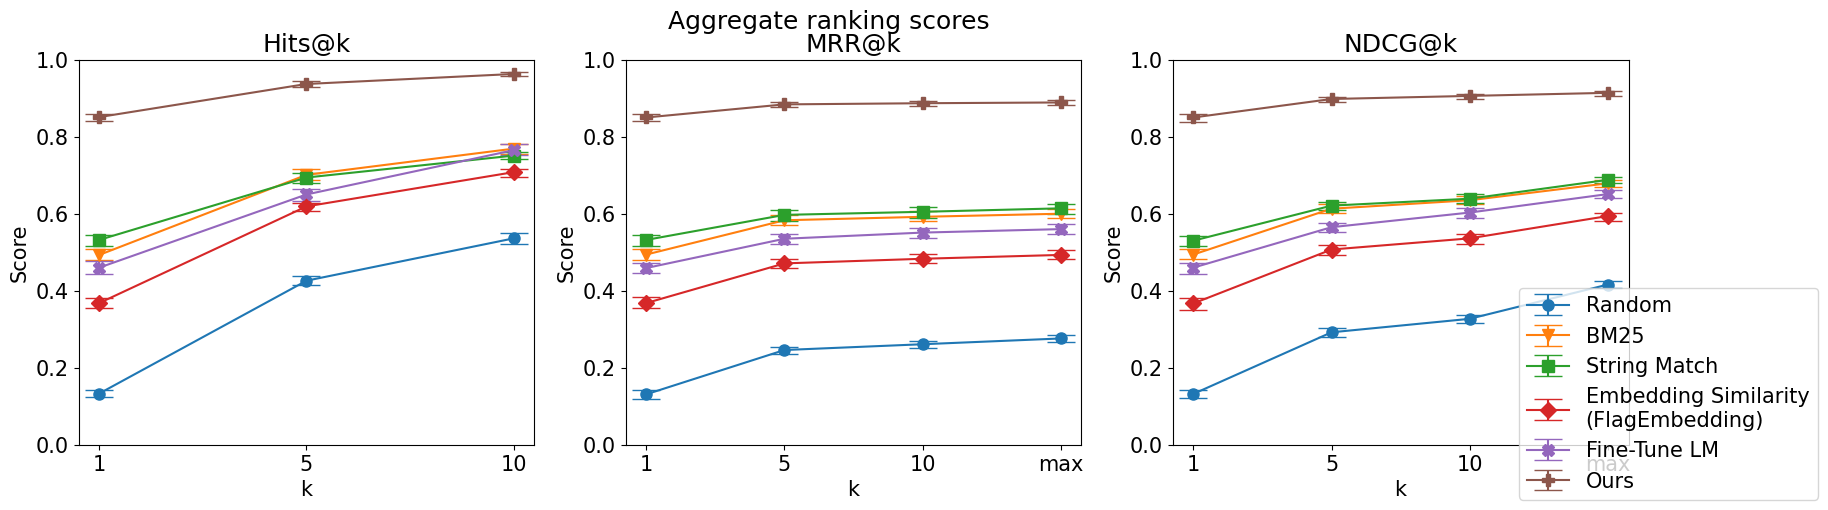

In [20]:
# Plot ranking scores
# create a grid of 1x3 plots
fig, axs = plt.subplots(1, 3, figsize=(20, 5))
fig.suptitle('Aggregate ranking scores')    
for ax in axs:
    ax.set_ylim(0, 1)
    ax.set_xlabel('k')
    ax.set_ylabel('Score')

axs[0].set_title('Hits@k')
for column, label, marker in zip(columns, labels, markers):
    axs[0].errorbar(hits_at_k[column].keys(), [hits_at_k[column][k]['score'] for k in hits_at_k[column].keys()], yerr=[[hits_at_k[column][k]['score'] - hits_at_k[column][k]['cl'][0] for k in hits_at_k[column].keys()], [hits_at_k[column][k]['cl'][1] - hits_at_k[column][k]['score'] for k in hits_at_k[column].keys()]], label=label, marker=marker, capsize=10, markersize=8)

axs[1].set_title('MRR@k')
for column, label, marker in zip(columns, labels, markers):
    axs[1].errorbar(mrr_at_k[column].keys(), [mrr_at_k[column][k]['score'] for k in mrr_at_k[column].keys()], yerr=[[mrr_at_k[column][k]['score'] - mrr_at_k[column][k]['cl'][0] for k in mrr_at_k[column].keys()], [mrr_at_k[column][k]['cl'][1] - mrr_at_k[column][k]['score'] for k in mrr_at_k[column].keys()]], label=label, marker=marker, capsize=10, markersize=8)

axs[2].set_title('NDCG@k')
for column, label, marker in zip(columns, labels, markers):
    axs[2].errorbar(ndcg_at_k[column].keys(), [ndcg_at_k[column][k]['score'] for k in ndcg_at_k[column].keys()], yerr=[[ndcg_at_k[column][k]['score'] - ndcg_at_k[column][k]['cl'][0] for k in ndcg_at_k[column].keys()], [ndcg_at_k[column][k]['cl'][1] - ndcg_at_k[column][k]['score'] for k in ndcg_at_k[column].keys()]], label=label, marker=marker, capsize=10, markersize=8)

handles, labels = axs[-1].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower right')

## Plot Stratified Results

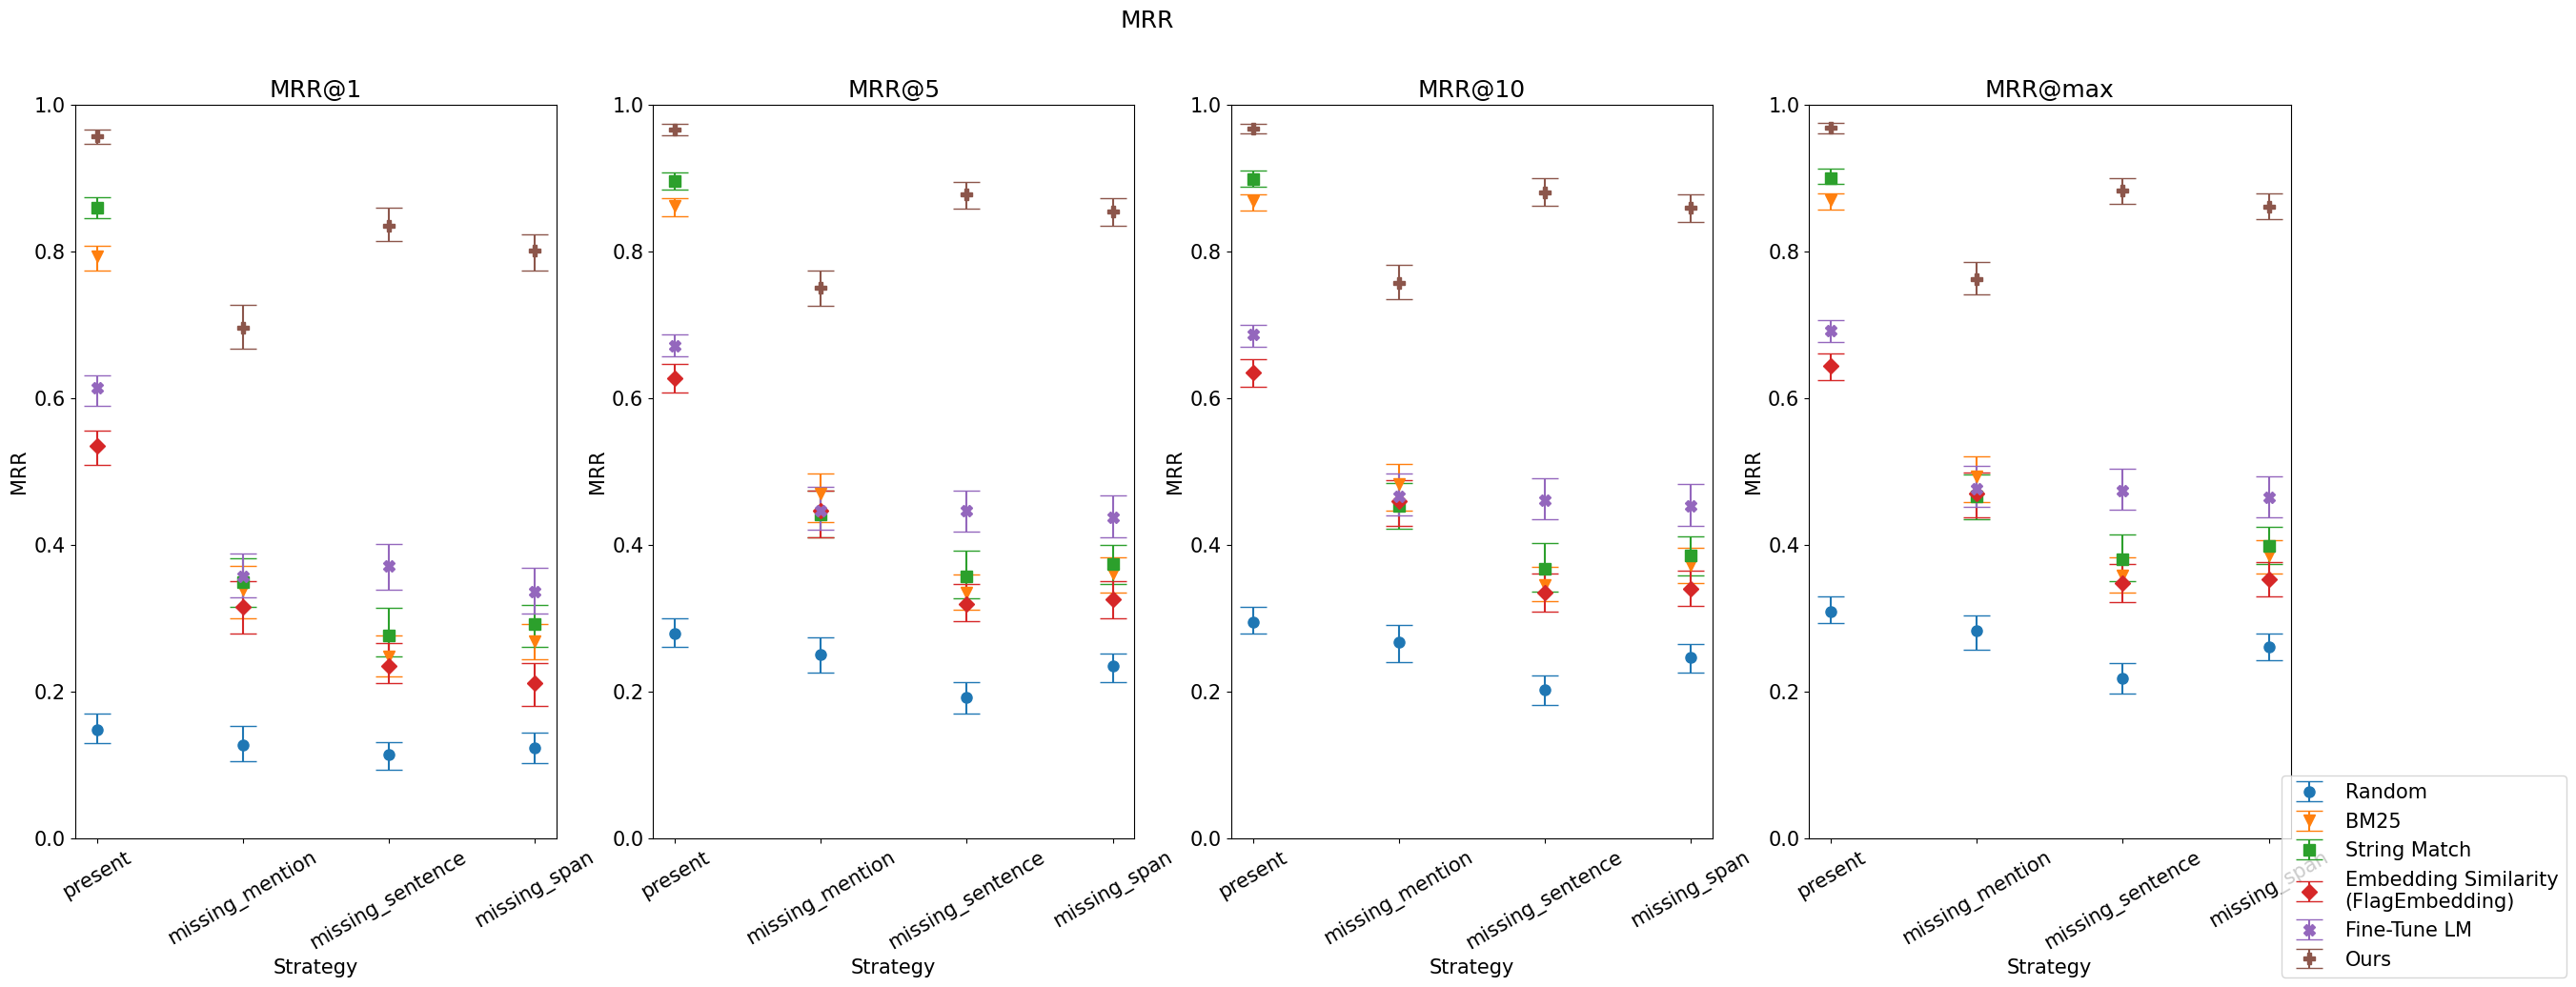

In [21]:
# Plot MRR stratified
# create a grid of 1xC plots, where C is the number of k values
# each plot should have the categories on the x axis and the MRR on the y axis

strategies = ['present', 'missing_mention', 'missing_sentence', 'missing_span']

fig, axs = plt.subplots(1, 4, figsize=(30, 10))
fig.suptitle('MRR')    
for ax in axs:
    ax.set_ylim(0, 1)
    ax.set_xlabel('Strategy')
    ax.set_ylabel('MRR')
    ax.set_title(f"MRR@{list(mrr_at_k[columns[0]].keys())[axs.tolist().index(ax)]}")
    
for column, label, marker in zip(columns, labels, markers):
    for i, k in enumerate(mrr_at_k[column].keys()):
        axs[i].errorbar(strategies, [stratified_mrr_at_k[column][s][k]['score'] for s in strategies], yerr=[[stratified_mrr_at_k[column][s][k]['score'] - stratified_mrr_at_k[column][s][k]['cl'][0] for s in strategies], [stratified_mrr_at_k[column][s][k]['cl'][1] - stratified_mrr_at_k[column][s][k]['score'] for s in strategies]], label=label, marker=marker, capsize=10, markersize=8, linestyle='None')

handles, labels = axs[-1].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower right')
# rotate x ticks
for ax in axs:
    plt.sca(ax)
    plt.xticks(rotation=30)

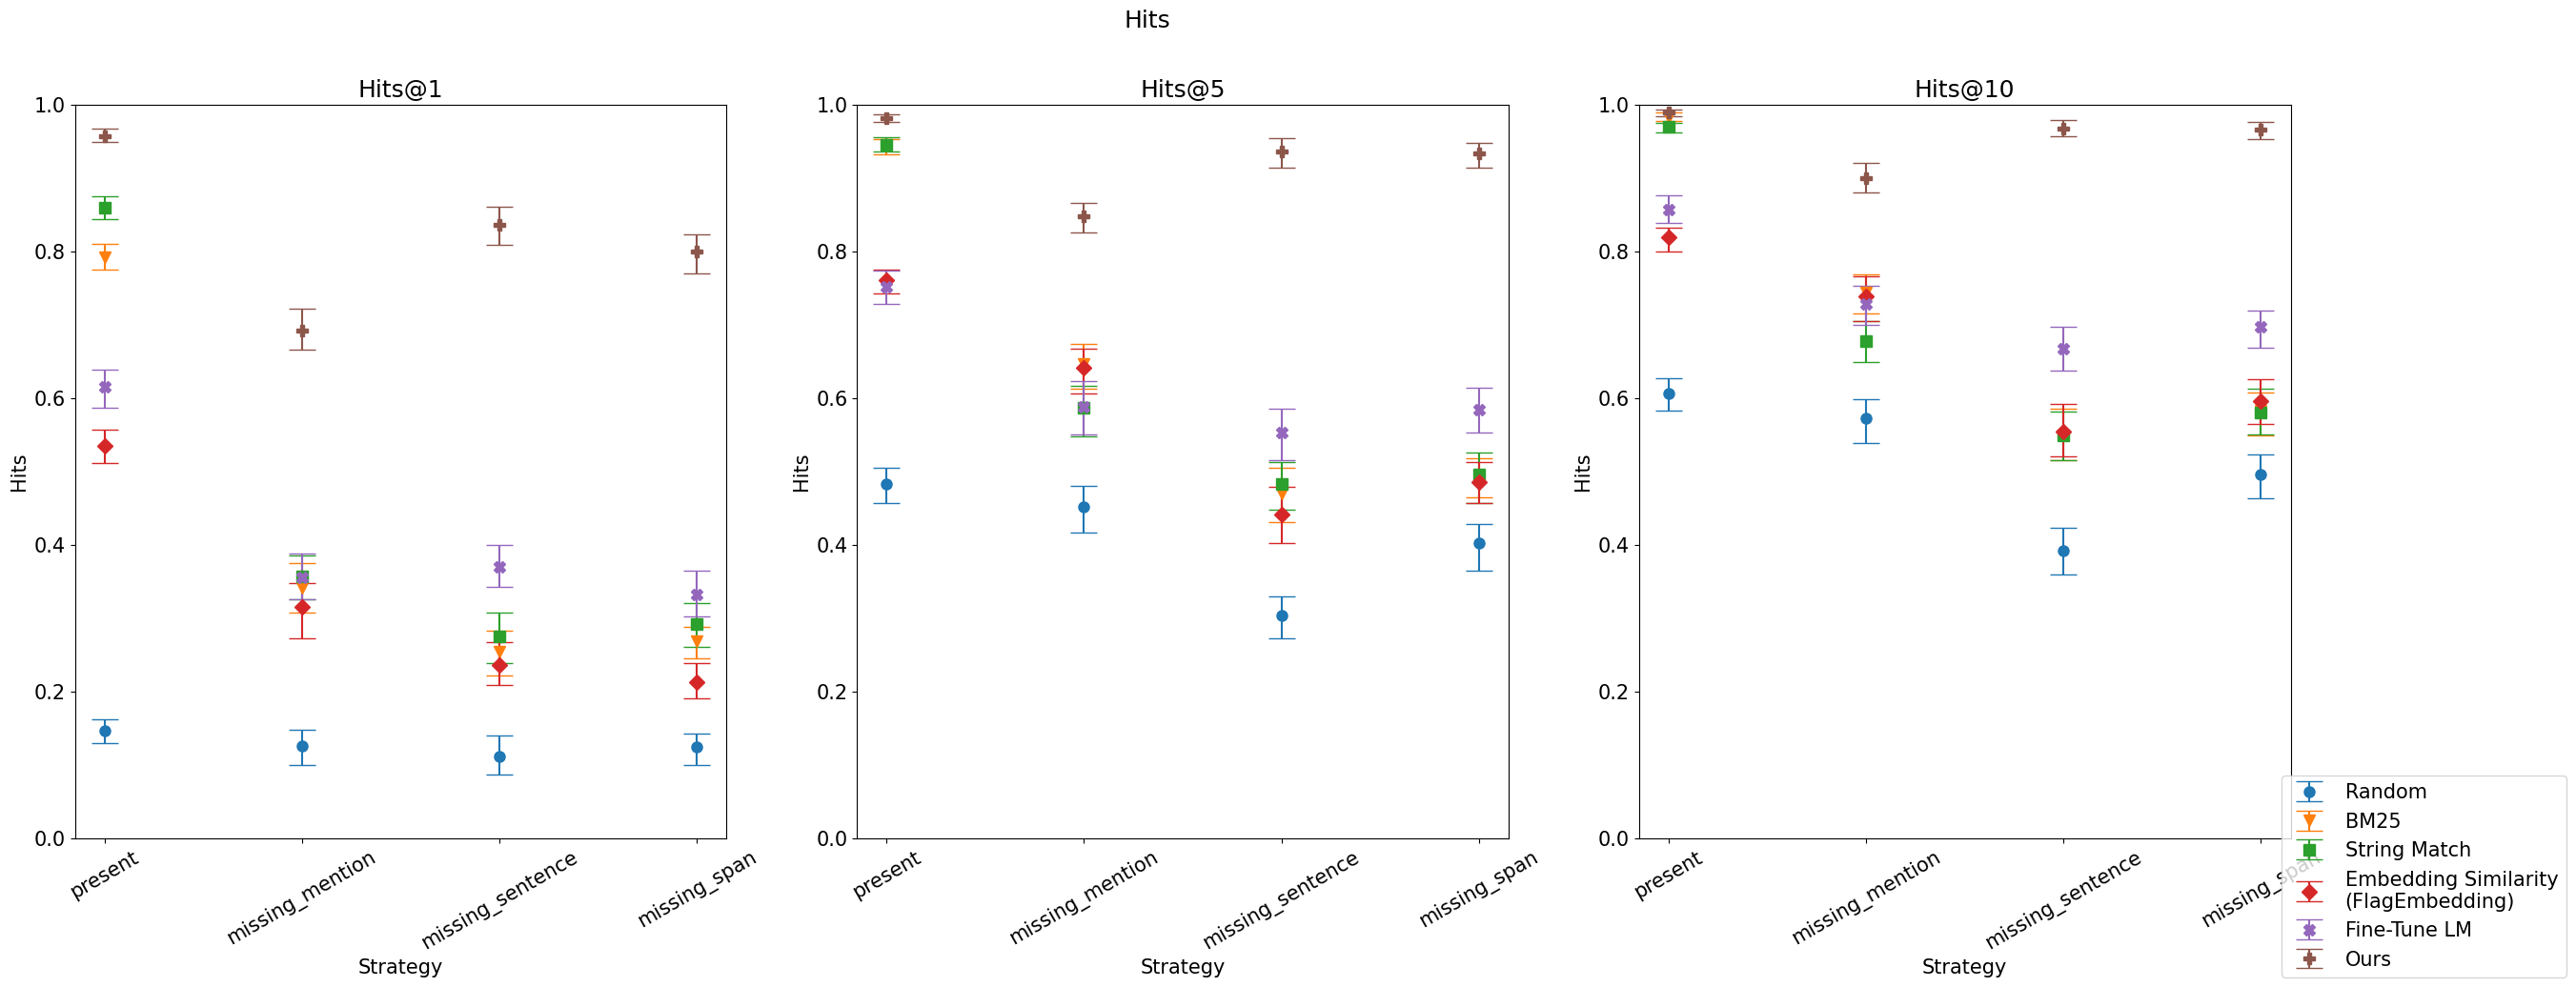

In [22]:
# Plot Hits stratified
# create a grid of 1xC plots, where C is the number of k values
# each plot should have the categories on the x axis and the hits on the y axis

strategies = ['present', 'missing_mention', 'missing_sentence', 'missing_span']

fig, axs = plt.subplots(1, 3, figsize=(30, 10))
fig.suptitle('Hits')
for ax in axs:
    ax.set_ylim(0, 1)
    ax.set_xlabel('Strategy')
    ax.set_ylabel('Hits')
    ax.set_title(f"Hits@{list(hits_at_k[columns[0]].keys())[axs.tolist().index(ax)]}")
    
for column, label, marker in zip(columns, labels, markers):
    for i, k in enumerate(hits_at_k[column].keys()):
        axs[i].errorbar(strategies, [stratified_hits_at_k[column][s][k]['score'] for s in strategies], yerr=[[stratified_hits_at_k[column][s][k]['score'] - stratified_hits_at_k[column][s][k]['cl'][0] for s in strategies], [stratified_hits_at_k[column][s][k]['cl'][1] - stratified_hits_at_k[column][s][k]['score'] for s in strategies]], label=label, marker=marker, capsize=10, markersize=8, linestyle='None')

handles, labels = axs[-1].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower right')

# rotate x ticks
for ax in axs:
    plt.sca(ax)
    plt.xticks(rotation=30)

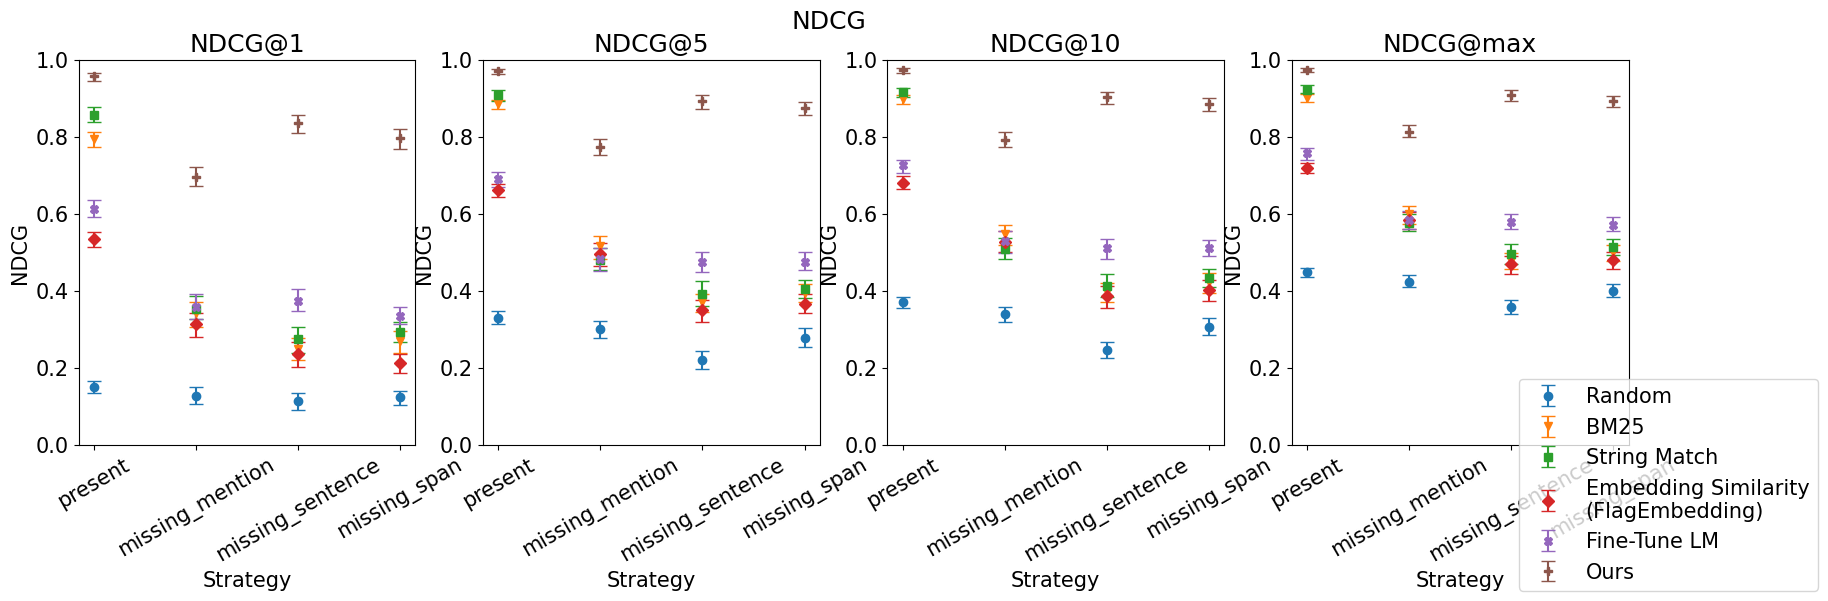

In [23]:
# Plot NDCG stratified
# create a grid of 1xC plots, where C is the number of k values
# each plot should have the categories on the x axis and the ndcg on the y axis

strategies = ['present', 'missing_mention', 'missing_sentence', 'missing_span']

fig, axs = plt.subplots(1, 4, figsize=(20, 5))
fig.suptitle('NDCG')

for ax in axs:
    ax.set_ylim(0, 1)
    ax.set_xlabel('Strategy')
    ax.set_ylabel('NDCG')
    ax.set_title(f"NDCG@{list(ndcg_at_k[columns[0]].keys())[axs.tolist().index(ax)]}")
    
for column, label, marker in zip(columns, labels, markers):
    for i, k in enumerate(ndcg_at_k[column].keys()):
        axs[i].errorbar(strategies, [stratified_ndcg_at_k[column][s][k]['score'] for s in strategies], yerr=[[stratified_ndcg_at_k[column][s][k]['score'] - stratified_ndcg_at_k[column][s][k]['cl'][0] for s in strategies], [stratified_ndcg_at_k[column][s][k]['cl'][1] - stratified_ndcg_at_k[column][s][k]['score'] for s in strategies]], label=label, marker=marker, capsize=5, linestyle='None')

handles, labels = axs[-1].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower right')    

# rotate x ticks
for ax in axs:
    plt.sca(ax)
    plt.xticks(rotation=30)

# Analysis of number of candidates with reduced metrics

In [24]:
test_df['number_candidates'].describe()

count    3212.000000
mean       73.911893
std       106.745937
min         2.000000
25%         4.000000
50%        19.000000
75%        81.000000
max       821.000000
Name: number_candidates, dtype: float64

In [25]:
test_df['number_candidates'].sum(), test_df['number_candidates'].sum()/ len(test_df), test_df['number_candidates'].std()

(237405, 73.91189290161893, 106.74593730449708)

Text(0.5, 1.0, 'Number of candidates distribution')

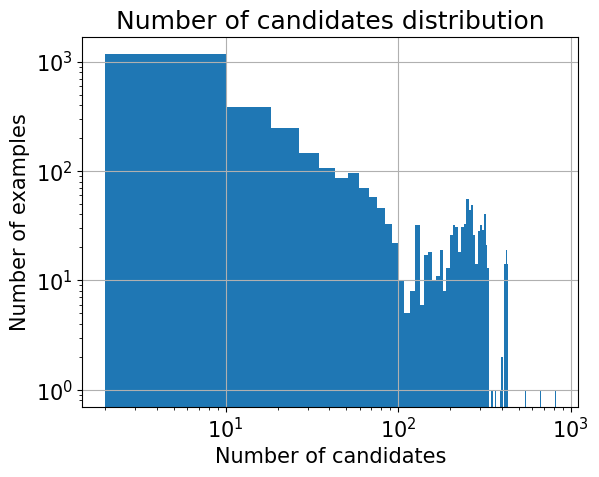

In [26]:
test_df['number_candidates'].hist(bins=100)
# set log x axis
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Number of candidates')
plt.ylabel('Number of examples')
plt.title('Number of candidates distribution')

In [27]:
bins_right_limits = [5, 10, 50, 100, 1000]
def find_bin(x):
    start = 0
    for limit in bins_right_limits:
        if x <= limit:
            return f"{start}-{limit}"
        start = limit
test_df['candidates_binned'] = test_df['number_candidates'].apply(find_bin)
test_df['candidates_binned'].value_counts()

candidates_binned
10-50       963
0-5         898
100-1000    735
50-100      334
5-10        282
Name: count, dtype: int64

In [28]:
binned_mrr_at_k = {}
binned_hits_at_k = {}
for bin in test_df['candidates_binned'].unique():
    binned_mrr_at_k[bin] = {}
    binned_hits_at_k[bin] = {}
    for column in test_df.columns:
        if 'rank' in column:
            binned_mrr_at_k[bin][column] = compute_stratified_mrr(test_df[test_df['candidates_binned'] == bin][column].tolist(), test_df[test_df['candidates_binned'] == bin]['missing_category'].tolist(), test_df[test_df['candidates_binned'] == bin]['missing_category'].unique())
            binned_hits_at_k[bin][column] = compute_stratified_hits(test_df[test_df['candidates_binned'] == bin][column].tolist(), test_df[test_df['candidates_binned'] == bin]['missing_category'].tolist(), test_df[test_df['candidates_binned'] == bin]['missing_category'].unique())


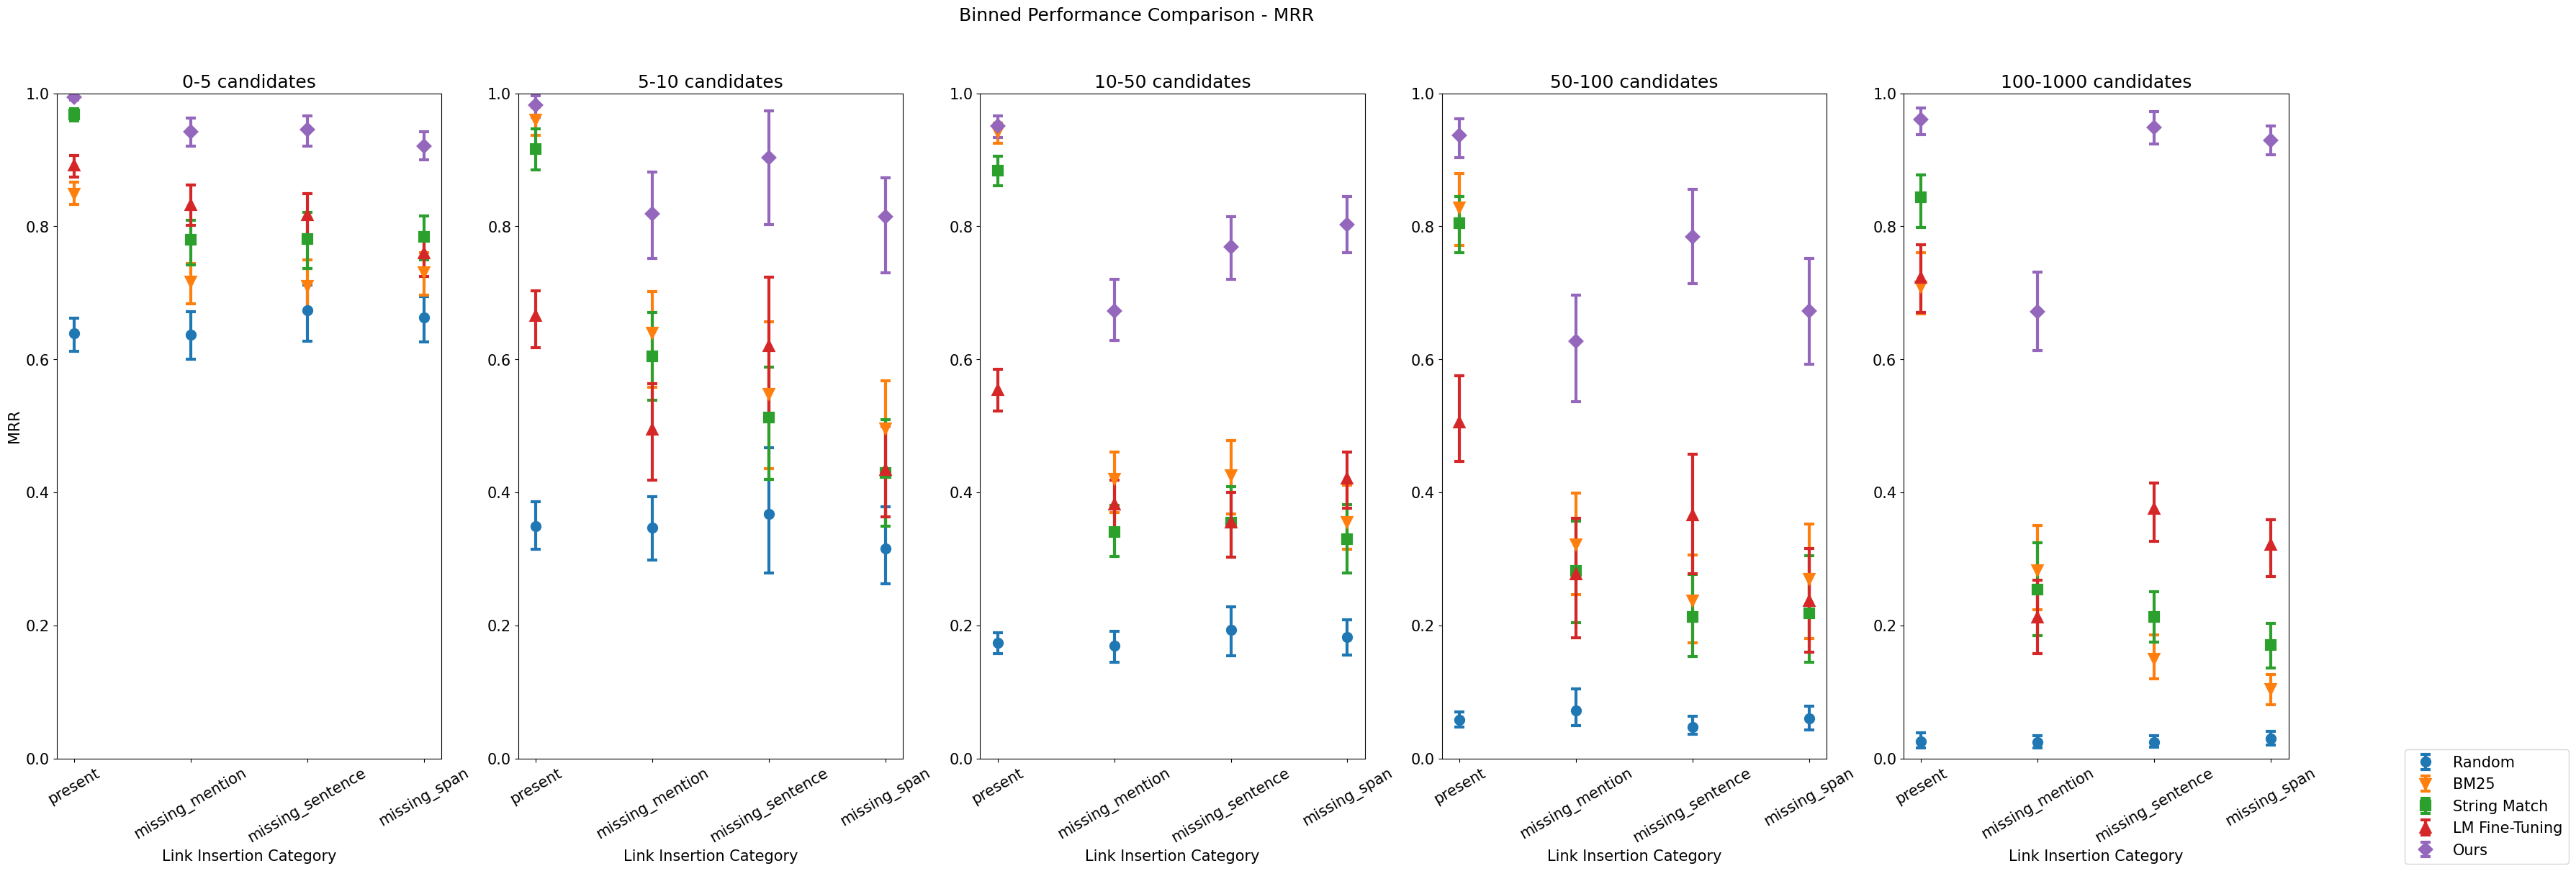

In [29]:
strategies = ['present', 'missing_mention', 'missing_sentence', 'missing_span']
bins = ['0-5', '5-10', '10-50', '50-100', '100-1000']
# columns = ['random_rank', 'bm25_mentions_rank', 'fuzzy_match_rank', 'model_ranking_rank', 'model_ranking_corrupt_section_mentions_rank']
# columns = ['random_rank', 'bm25_mentions_rank', 'fuzzy_match_rank', 'model_ranking_corrupt_section_mentions_rank']
columns = ['random_rank', 'bm25_mentions_rank', 'fuzzy_match_rank', 'roberta_simple_v2_rank', 'roberta_two_stage_v2_rank']
labels = ['Random', 'BM25', 'String Match', 'LM Fine-Tuning', 'Ours']
markers = ['o', 'v', 's', '^', 'D']

fig, axs = plt.subplots(1, 5, figsize=(40, 12))
fig.suptitle('Binned Performance Comparison - MRR')
axs[0].set_ylabel('MRR')
for i, ax in enumerate(axs):
    ax.set_ylim(0, 1)
    ax.set_xlabel('Link Insertion Category')
    ax.set_title(F'{bins[i]} candidates')
    
for column, label, marker in zip(columns, labels, markers):
    for i, bin in enumerate(bins):
        axs[i].errorbar(strategies, [binned_mrr_at_k[bin][column][s]['max']['score'] for s in strategies], yerr=[[binned_mrr_at_k[bin][column][s]['max']['score'] - binned_mrr_at_k[bin][column][s]['max']['cl'][0] for s in strategies], [binned_mrr_at_k[bin][column][s]['max']['cl'][1] - binned_mrr_at_k[bin][column][s]['max']['score'] for s in strategies]], label=label, marker=marker, capsize=5, linestyle='None', markersize=8, elinewidth=3, markeredgewidth=3)

handles, labels = axs[-1].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower right')

# rotate x ticks
for ax in axs:
    plt.sca(ax)
    plt.xticks(rotation=30)

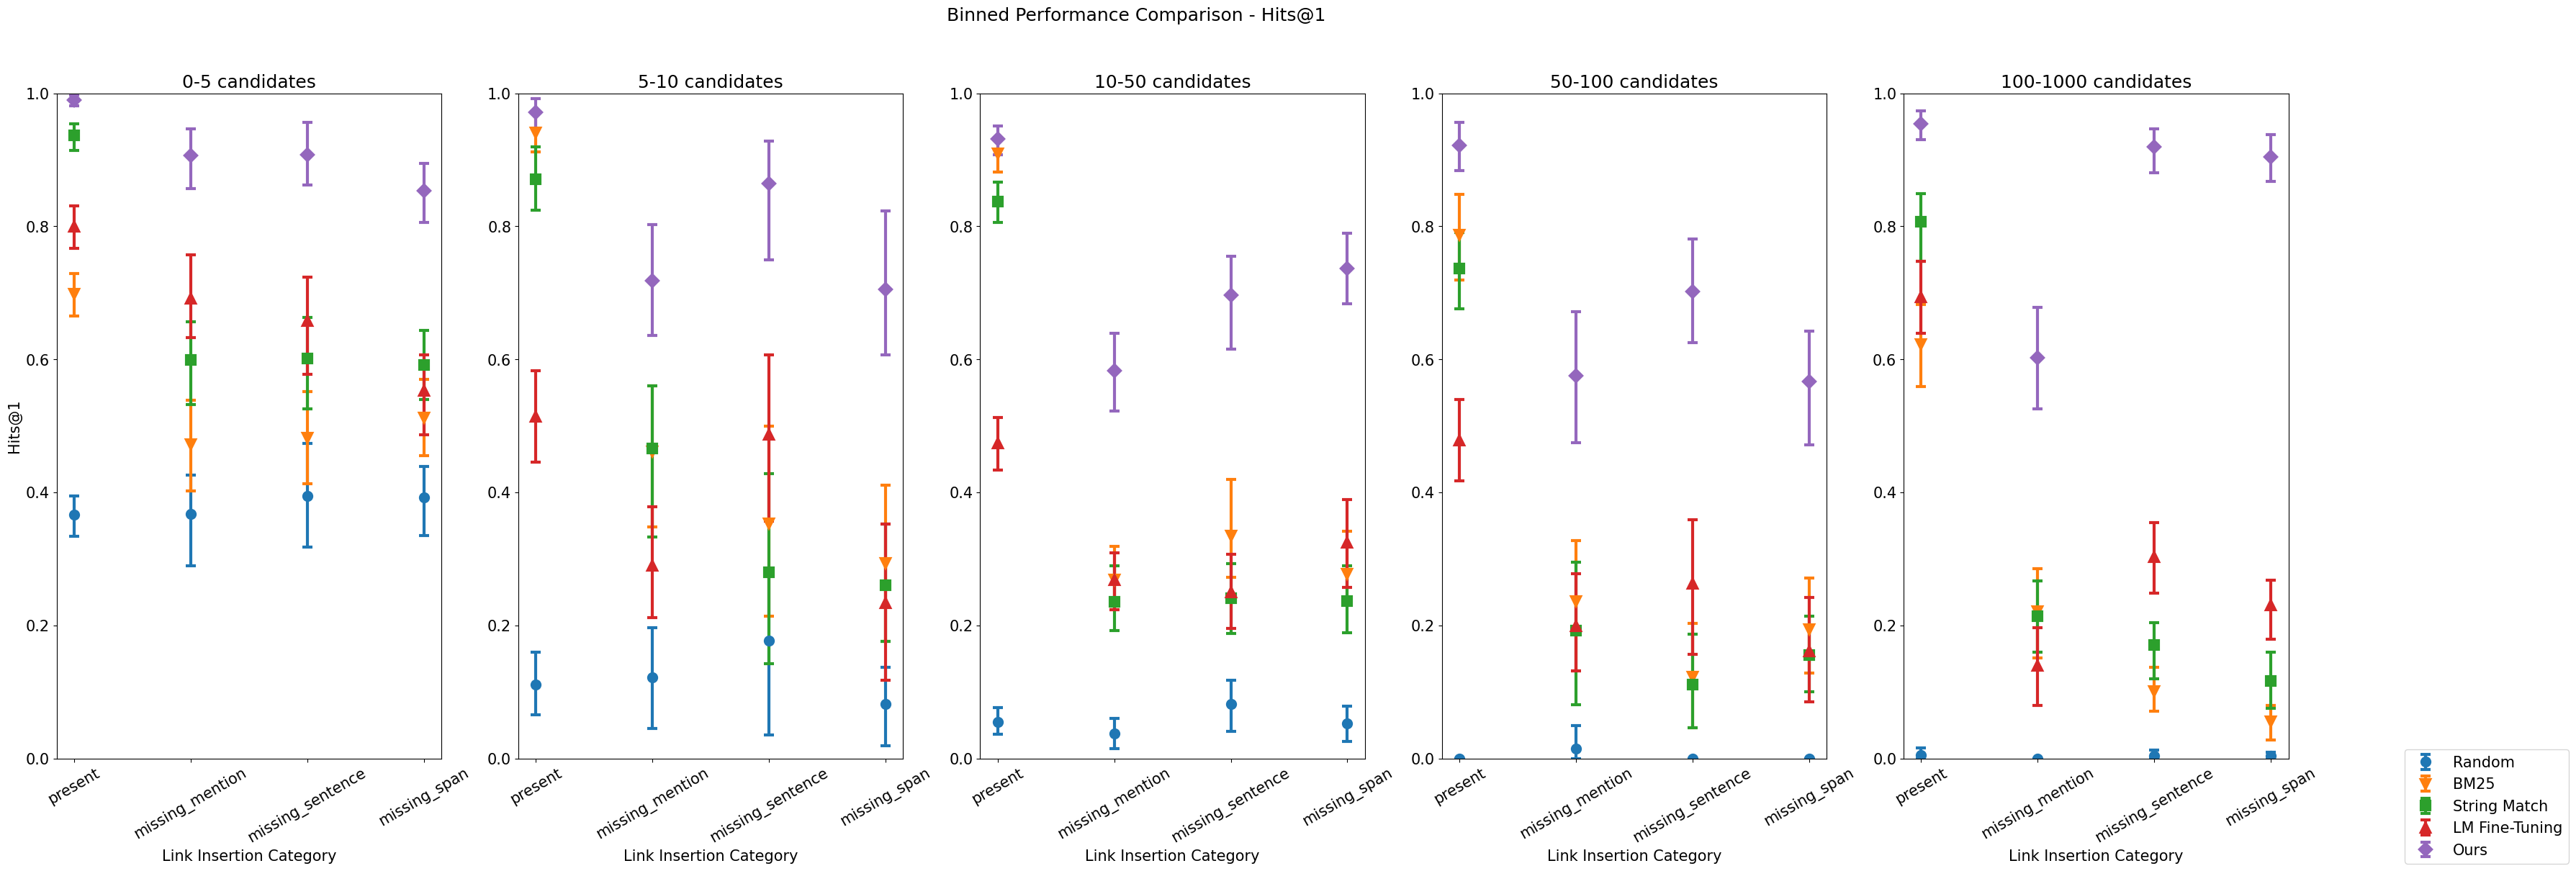

In [30]:
fig, axs = plt.subplots(1, 5, figsize=(40, 12))
fig.suptitle('Binned Performance Comparison - Hits@1')
axs[0].set_ylabel('Hits@1')
for i, ax in enumerate(axs):
    ax.set_ylim(0, 1)
    ax.set_xlabel('Link Insertion Category')
    ax.set_title(F'{bins[i]} candidates')
    
for column, label, marker in zip(columns, labels, markers):
    for i, bin in enumerate(bins):
        axs[i].errorbar(strategies, [binned_hits_at_k[bin][column][s]['1']['score'] for s in strategies], yerr=[[binned_hits_at_k[bin][column][s]['1']['score'] - binned_hits_at_k[bin][column][s]['1']['cl'][0] for s in strategies], [binned_hits_at_k[bin][column][s]['1']['cl'][1] - binned_hits_at_k[bin][column][s]['1']['score'] for s in strategies]], label=label, marker=marker, capsize=5, linestyle='None', markersize=8, elinewidth=3, markeredgewidth=3)
        
handles, labels = axs[-1].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower right')

# rotate x ticks
for ax in axs:
    plt.sca(ax)
    plt.xticks(rotation=30)

# Additional plots

## Compare model size

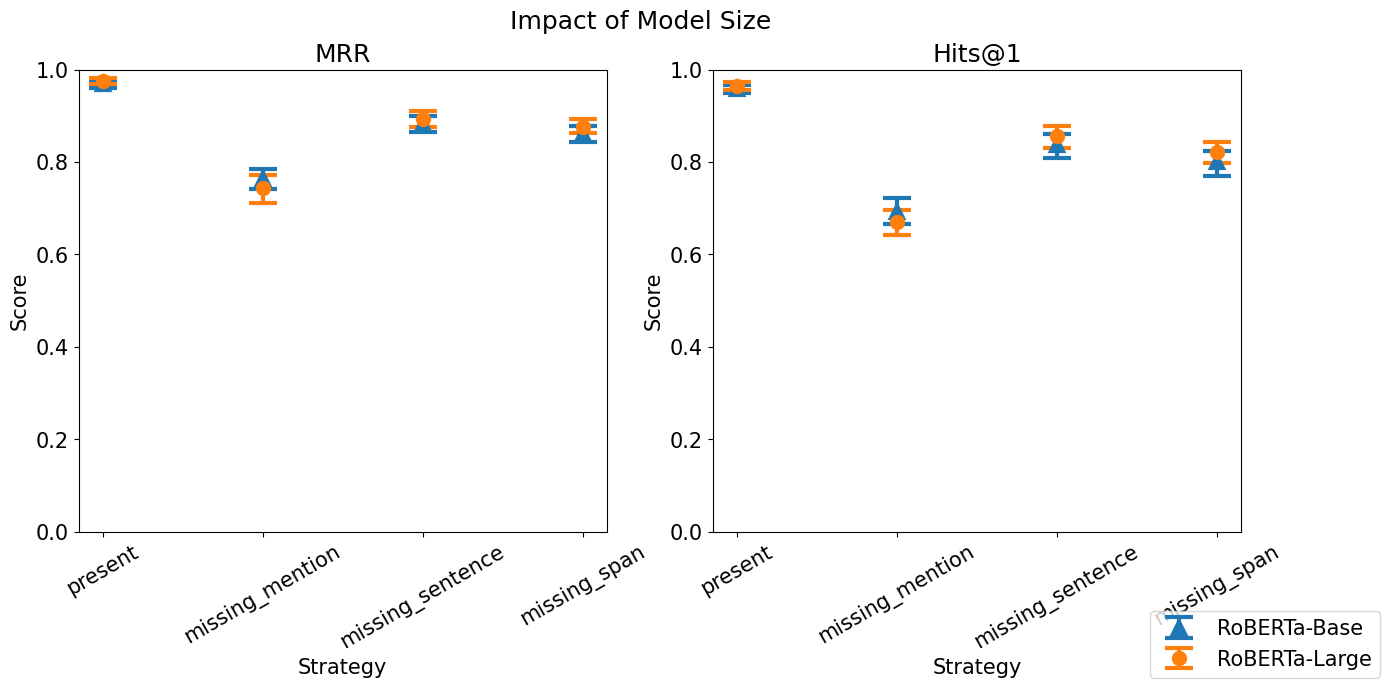

In [31]:
columns = ['roberta_two_stage_v2_rank', 'roberta_large_two_stage_rank']
labels = ['RoBERTa-Base', 'RoBERTa-Large']
markers = ['^', 'o', 'X']
strategies = ['present', 'missing_mention', 'missing_sentence', 'missing_span']

fig, axs = plt.subplots(1, 2, figsize=(15, 6))
fig.suptitle('Impact of Model Size')
for i, ax in enumerate(axs):
    ax.set_ylim(0, 1)
    ax.set_xlabel('Strategy')
    ax.set_ylabel('Score')
    ax.set_title("MRR" if i == 0 else "Hits@1")

for column, label, marker in zip(columns, labels, markers):
    # plot MRR@max in the first plot
    # plot Hits@1 in the second plot
    axs[0].errorbar(strategies, [stratified_mrr_at_k[column][s]['max']['score'] for s in strategies], yerr=[[stratified_mrr_at_k[column][s]['max']['score'] - stratified_mrr_at_k[column][s]['max']['cl'][0] for s in strategies], [stratified_mrr_at_k[column][s]['max']['cl'][1] - stratified_mrr_at_k[column][s]['max']['score'] for s in strategies]], label=label, marker=marker, capsize=10, markersize=8, linestyle='None', elinewidth=3, markeredgewidth=3)
    axs[1].errorbar(strategies, [stratified_hits_at_k[column][s]['1']['score'] for s in strategies], yerr=[[stratified_hits_at_k[column][s]['1']['score'] - stratified_hits_at_k[column][s]['1']['cl'][0] for s in strategies], [stratified_hits_at_k[column][s]['1']['cl'][1] - stratified_hits_at_k[column][s]['1']['score'] for s in strategies]], label=label, marker=marker, capsize=10, markersize=8, linestyle='None', elinewidth=3, markeredgewidth=3)

handles, labels = axs[-1].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower right')

# rotate x ticks
for ax in axs:
    plt.sca(ax)
    plt.xticks(rotation=30)

In [32]:
for column in columns:
    for strategy in strategies:
        # print score and confidence interval for each strategy for each column
        print(f"{column} {strategy} MRR@max: {stratified_mrr_at_k[column][strategy]['max']['score']} {stratified_mrr_at_k[column][strategy]['max']['cl']}")
        print(f"{column} {strategy} Hits@1: {stratified_hits_at_k[column][strategy]['1']['score']} {stratified_hits_at_k[column][strategy]['1']['cl']}")

roberta_two_stage_v2_rank present MRR@max: 0.968 [0.96, 0.975]
roberta_two_stage_v2_rank present Hits@1: 0.957 [0.949, 0.967]
roberta_two_stage_v2_rank missing_mention MRR@max: 0.762 [0.741, 0.785]
roberta_two_stage_v2_rank missing_mention Hits@1: 0.692 [0.666, 0.722]
roberta_two_stage_v2_rank missing_sentence MRR@max: 0.882 [0.864, 0.9]
roberta_two_stage_v2_rank missing_sentence Hits@1: 0.836 [0.809, 0.861]
roberta_two_stage_v2_rank missing_span MRR@max: 0.861 [0.843, 0.878]
roberta_two_stage_v2_rank missing_span Hits@1: 0.8 [0.77, 0.823]
roberta_large_two_stage_rank present MRR@max: 0.975 [0.968, 0.981]
roberta_large_two_stage_rank present Hits@1: 0.965 [0.955, 0.974]
roberta_large_two_stage_rank missing_mention MRR@max: 0.743 [0.712, 0.772]
roberta_large_two_stage_rank missing_mention Hits@1: 0.671 [0.641, 0.697]
roberta_large_two_stage_rank missing_sentence MRR@max: 0.893 [0.875, 0.911]
roberta_large_two_stage_rank missing_sentence Hits@1: 0.856 [0.831, 0.878]
roberta_large_two_sta

In [33]:
from scipy.stats import ttest_ind
# compute pair-wise p-values for each strategy
for i, column_1 in enumerate(columns):
    for column_2 in columns[i+1:]:
        for strategy in strategies:
            ranks_1 = test_df[test_df['missing_category'] == strategy][column_1].tolist()
            ranks_2 = test_df[test_df['missing_category'] == strategy][column_2].tolist()
            
            hits_at_1_1 = [1 if rank <= 1 else 0 for rank in ranks_1]
            hits_at_1_2 = [1 if rank <= 1 else 0 for rank in ranks_2]
            
            mrr_1 = [1 / rank for rank in ranks_1]
            mrr_2 = [1 / rank for rank in ranks_2]
            
            # compute the p-values
            print(f"{column_1} vs {column_2} for {strategy}")
            print(f"\tMRR@max: {ttest_ind(mrr_1, mrr_2)}")
            print(f"\tHits@1: {ttest_ind(hits_at_1_1, hits_at_1_2)}")

roberta_two_stage_v2_rank vs roberta_large_two_stage_rank for present
	MRR@max: TtestResult(statistic=-1.3837161760924415, pvalue=0.16656271269754255, df=2632.0)
	Hits@1: TtestResult(statistic=-1.1055331112545288, pvalue=0.26902969860992204, df=2632.0)
roberta_two_stage_v2_rank vs roberta_large_two_stage_rank for missing_mention
	MRR@max: TtestResult(statistic=0.7469530299969079, pvalue=0.45523726889047533, df=1208.0)
	Hits@1: TtestResult(statistic=0.8642514004459944, pvalue=0.38762137661667906, df=1208.0)
roberta_two_stage_v2_rank vs roberta_large_two_stage_rank for missing_sentence
	MRR@max: TtestResult(statistic=-0.689367922296259, pvalue=0.49073083249036265, df=1150.0)
	Hits@1: TtestResult(statistic=-0.9777349069634041, pvalue=0.3284110824069384, df=1150.0)
roberta_two_stage_v2_rank vs roberta_large_two_stage_rank for missing_span
	MRR@max: TtestResult(statistic=-0.8922886810334115, pvalue=0.3723887615601661, df=1426.0)
	Hits@1: TtestResult(statistic=-1.0809894425605318, pvalue=0.2

## Compare RoBERTa with BERT

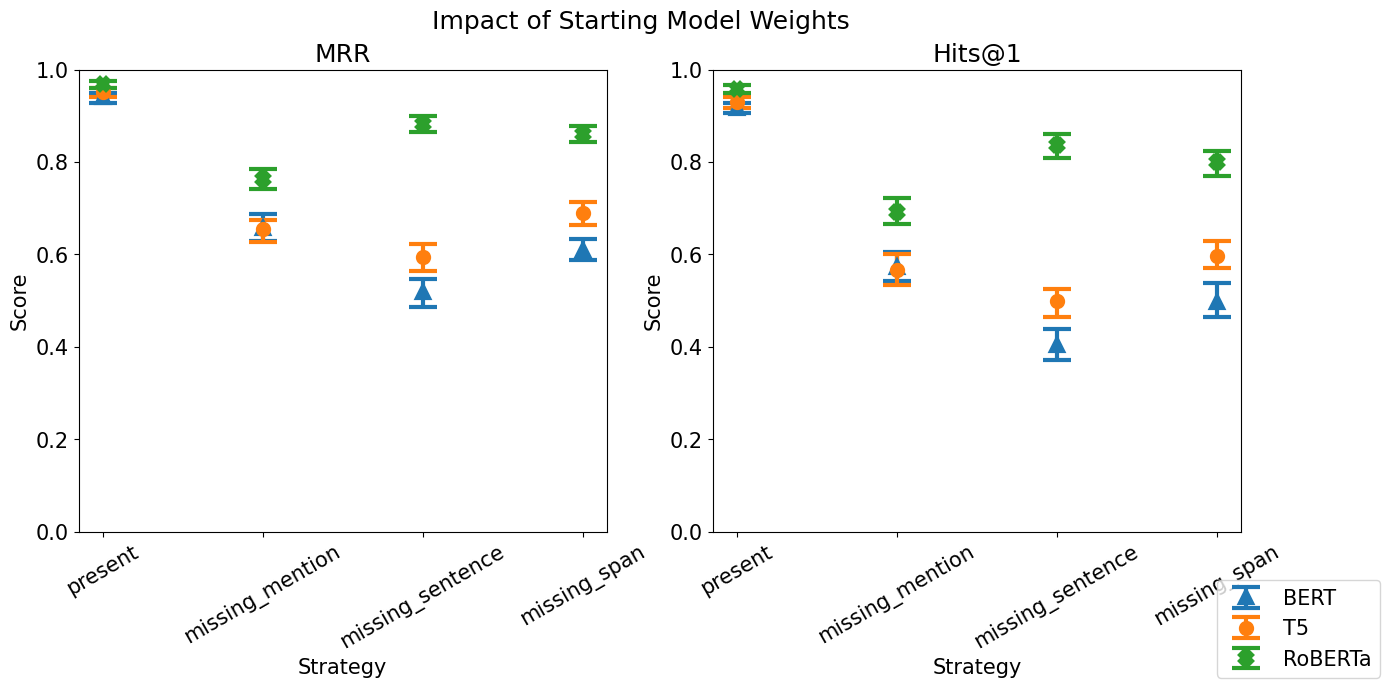

In [34]:
columns = ['bert_two_stage_v2_rank', 't5_two_stage_v2_rank', 'roberta_two_stage_v2_rank']
labels = ['BERT', 'T5', 'RoBERTa']
markers = ['^', 'o', 'X']
strategies = ['present', 'missing_mention', 'missing_sentence', 'missing_span']

fig, axs = plt.subplots(1, 2, figsize=(15, 6))
fig.suptitle('Impact of Starting Model Weights')
for i, ax in enumerate(axs):
    ax.set_ylim(0, 1)
    ax.set_xlabel('Strategy')
    ax.set_ylabel('Score')
    ax.set_title("MRR" if i == 0 else "Hits@1")

for column, label, marker in zip(columns, labels, markers):
    # plot MRR@max in the first plot
    # plot Hits@1 in the second plot
    axs[0].errorbar(strategies, [stratified_mrr_at_k[column][s]['max']['score'] for s in strategies], yerr=[[stratified_mrr_at_k[column][s]['max']['score'] - stratified_mrr_at_k[column][s]['max']['cl'][0] for s in strategies], [stratified_mrr_at_k[column][s]['max']['cl'][1] - stratified_mrr_at_k[column][s]['max']['score'] for s in strategies]], label=label, marker=marker, capsize=10, markersize=8, linestyle='None', elinewidth=3, markeredgewidth=3)
    axs[1].errorbar(strategies, [stratified_hits_at_k[column][s]['1']['score'] for s in strategies], yerr=[[stratified_hits_at_k[column][s]['1']['score'] - stratified_hits_at_k[column][s]['1']['cl'][0] for s in strategies], [stratified_hits_at_k[column][s]['1']['cl'][1] - stratified_hits_at_k[column][s]['1']['score'] for s in strategies]], label=label, marker=marker, capsize=10, markersize=8, linestyle='None', elinewidth=3, markeredgewidth=3)

handles, labels = axs[-1].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower right')

# rotate x ticks
for ax in axs:
    plt.sca(ax)
    plt.xticks(rotation=30)

In [35]:
for column in columns:
    for strategy in strategies:
        # print score and confidence interval for each strategy for each column
        print(f"{column} {strategy} MRR@max: {stratified_mrr_at_k[column][strategy]['max']['score']} {stratified_mrr_at_k[column][strategy]['max']['cl']}")
        print(f"{column} {strategy} Hits@1: {stratified_hits_at_k[column][strategy]['1']['score']} {stratified_hits_at_k[column][strategy]['1']['cl']}")

bert_two_stage_v2_rank present MRR@max: 0.94 [0.928, 0.949]
bert_two_stage_v2_rank present Hits@1: 0.916 [0.906, 0.928]
bert_two_stage_v2_rank missing_mention MRR@max: 0.657 [0.628, 0.688]
bert_two_stage_v2_rank missing_mention Hits@1: 0.572 [0.542, 0.604]
bert_two_stage_v2_rank missing_sentence MRR@max: 0.518 [0.487, 0.546]
bert_two_stage_v2_rank missing_sentence Hits@1: 0.404 [0.371, 0.439]
bert_two_stage_v2_rank missing_span MRR@max: 0.609 [0.588, 0.633]
bert_two_stage_v2_rank missing_span Hits@1: 0.497 [0.464, 0.537]
t5_two_stage_v2_rank present MRR@max: 0.951 [0.941, 0.959]
t5_two_stage_v2_rank present Hits@1: 0.929 [0.916, 0.941]
t5_two_stage_v2_rank missing_mention MRR@max: 0.655 [0.626, 0.675]
t5_two_stage_v2_rank missing_mention Hits@1: 0.566 [0.533, 0.6]
t5_two_stage_v2_rank missing_sentence MRR@max: 0.594 [0.563, 0.623]
t5_two_stage_v2_rank missing_sentence Hits@1: 0.498 [0.465, 0.524]
t5_two_stage_v2_rank missing_span MRR@max: 0.69 [0.664, 0.714]
t5_two_stage_v2_rank missin

In [36]:
from scipy.stats import ttest_ind
# compute pair-wise p-values for each strategy
for i, column_1 in enumerate(columns):
    for column_2 in columns[i+1:]:
        for strategy in strategies:
            ranks_1 = test_df[test_df['missing_category'] == strategy][column_1].tolist()
            ranks_2 = test_df[test_df['missing_category'] == strategy][column_2].tolist()
            
            hits_at_1_1 = [1 if rank <= 1 else 0 for rank in ranks_1]
            hits_at_1_2 = [1 if rank <= 1 else 0 for rank in ranks_2]
            
            mrr_1 = [1 / rank for rank in ranks_1]
            mrr_2 = [1 / rank for rank in ranks_2]
            
            # compute the p-values
            print(f"{column_1} vs {column_2} for {strategy}")
            print(f"\tMRR@max: {ttest_ind(mrr_1, mrr_2)}")
            print(f"\tHits@1: {ttest_ind(hits_at_1_1, hits_at_1_2)}")

bert_two_stage_v2_rank vs t5_two_stage_v2_rank for present
	MRR@max: TtestResult(statistic=-1.5641045386528054, pvalue=0.11791323792257889, df=2632.0)
	Hits@1: TtestResult(statistic=-1.2418769568054904, pvalue=0.21439261315486222, df=2632.0)
bert_two_stage_v2_rank vs t5_two_stage_v2_rank for missing_mention
	MRR@max: TtestResult(statistic=0.16436076948027956, pvalue=0.8694746413506925, df=1208.0)
	Hits@1: TtestResult(statistic=0.23199234898776733, pvalue=0.8165832497396223, df=1208.0)
bert_two_stage_v2_rank vs t5_two_stage_v2_rank for missing_sentence
	MRR@max: TtestResult(statistic=-3.0864132252559418, pvalue=0.0020743109596707988, df=1150.0)
	Hits@1: TtestResult(statistic=-3.3285783361185213, pvalue=0.0009005564363101413, df=1150.0)
bert_two_stage_v2_rank vs t5_two_stage_v2_rank for missing_span
	MRR@max: TtestResult(statistic=-3.71556216784151, pvalue=0.00021058572775632203, df=1426.0)
	Hits@1: TtestResult(statistic=-3.845142759761752, pvalue=0.00012578938826187045, df=1426.0)
bert_

## Compare Vanilla BM25 with Mention-Aware BM25

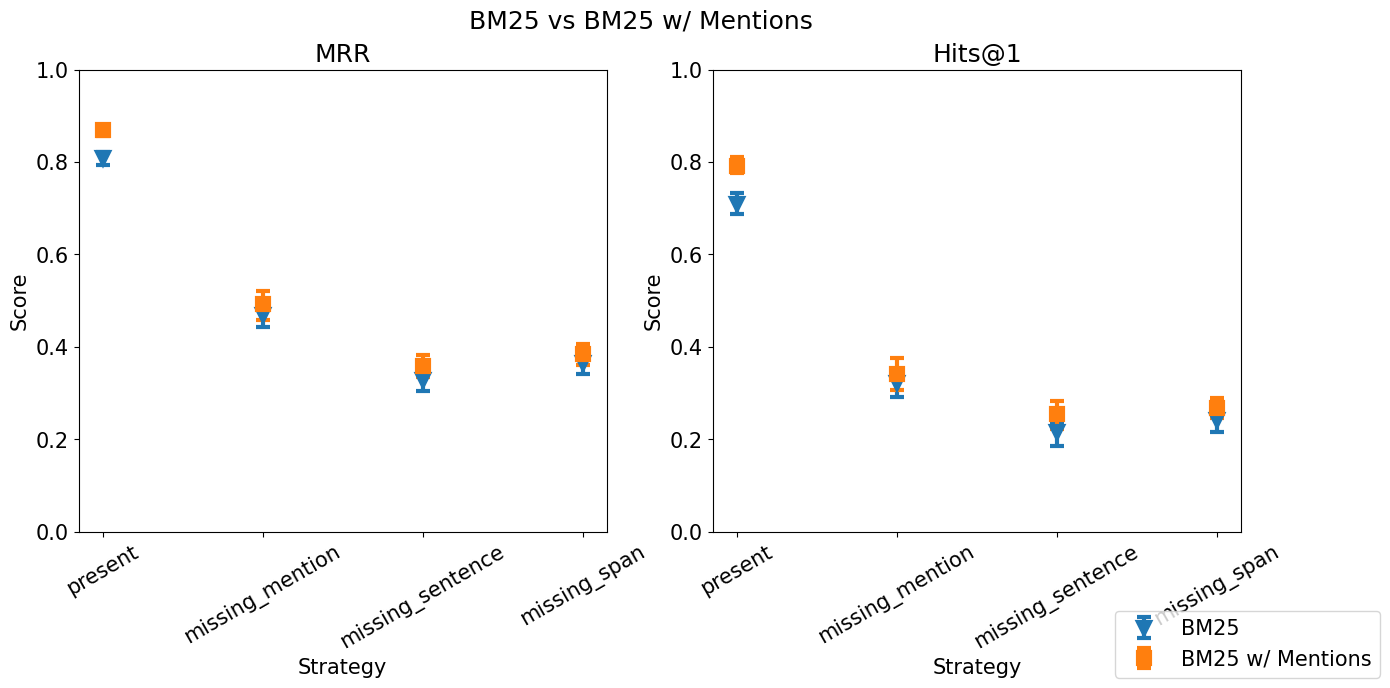

In [37]:
strategies = ['present', 'missing_mention', 'missing_sentence', 'missing_span']
columns = ['bm25_rank', 'bm25_mentions_rank']
labels = ['BM25', 'BM25 w/ Mentions']
markers = ['v', 's']

fig, axs = plt.subplots(1, 2, figsize=(15, 6))
fig.suptitle('BM25 vs BM25 w/ Mentions')
for i, ax in enumerate(axs):
    ax.set_ylim(0, 1)
    ax.set_xlabel('Strategy')
    ax.set_ylabel('Score')
    ax.set_title("MRR" if i == 0 else "Hits@1")

for column, label, marker in zip(columns, labels, markers):
    axs[0].errorbar(strategies, [stratified_mrr_at_k[column][s]['max']['score'] for s in strategies], yerr=[[stratified_mrr_at_k[column][s]['max']['score'] - stratified_mrr_at_k[column][s]['max']['cl'][0] for s in strategies], [stratified_mrr_at_k[column][s]['max']['cl'][1] - stratified_mrr_at_k[column][s]['max']['score'] for s in strategies]], label=label, marker=marker, capsize=5, linestyle='None', markersize=8, elinewidth=3, markeredgewidth=3)
    axs[1].errorbar(strategies, [stratified_hits_at_k[column][s]['1']['score'] for s in strategies], yerr=[[stratified_hits_at_k[column][s]['1']['score'] - stratified_hits_at_k[column][s]['1']['cl'][0] for s in strategies], [stratified_hits_at_k[column][s]['1']['cl'][1] - stratified_hits_at_k[column][s]['1']['score'] for s in strategies]], label=label, marker=marker, capsize=5, linestyle='None', markersize=8, elinewidth=3, markeredgewidth=3)

handles, labels = axs[-1].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower right')

# rotate x ticks
for ax in axs:
    plt.sca(ax)
    plt.xticks(rotation=30)

# Compare all the model variations

In [38]:
test_df.columns

Index(['source_title', 'source_ID', 'target_title', 'context', 'section',
       'mention_present', 'source_lead', 'first_version', 'second_version',
       'direct_match', 'missing_category', 'negative_contexts',
       'current_links', 'target_lead', 'random_rank', 'bm25_rank',
       'bm25_mentions_rank', 'exact_match_rank', 'fuzzy_match_rank',
       'bert_two_stage_rank', 'roberta_simple_rank', 'roberta_mask_rank',
       'roberta_mask_section_rank', 'roberta_mask_section_mention_rank',
       'roberta_two_stage_rank', 'roberta_only_stage_two_rank',
       'bert_two_stage_v2_rank', 'roberta_simple_v2_rank',
       'roberta_mask_v2_rank', 'roberta_mask_section_v2_rank',
       'roberta_two_stage_v2_rank', 'roberta_only_stage_two_v2_rank',
       'roberta_two_stage_no_corrupt_v2_rank',
       'roberta_mask_section_mention_v2_rank', 'embedding_similarity_rank',
       't5_two_stage_v2_rank', 'roberta_large_two_stage_rank',
       'roberta_stage_2_100', 'roberta_stage_2_1000', 'robert

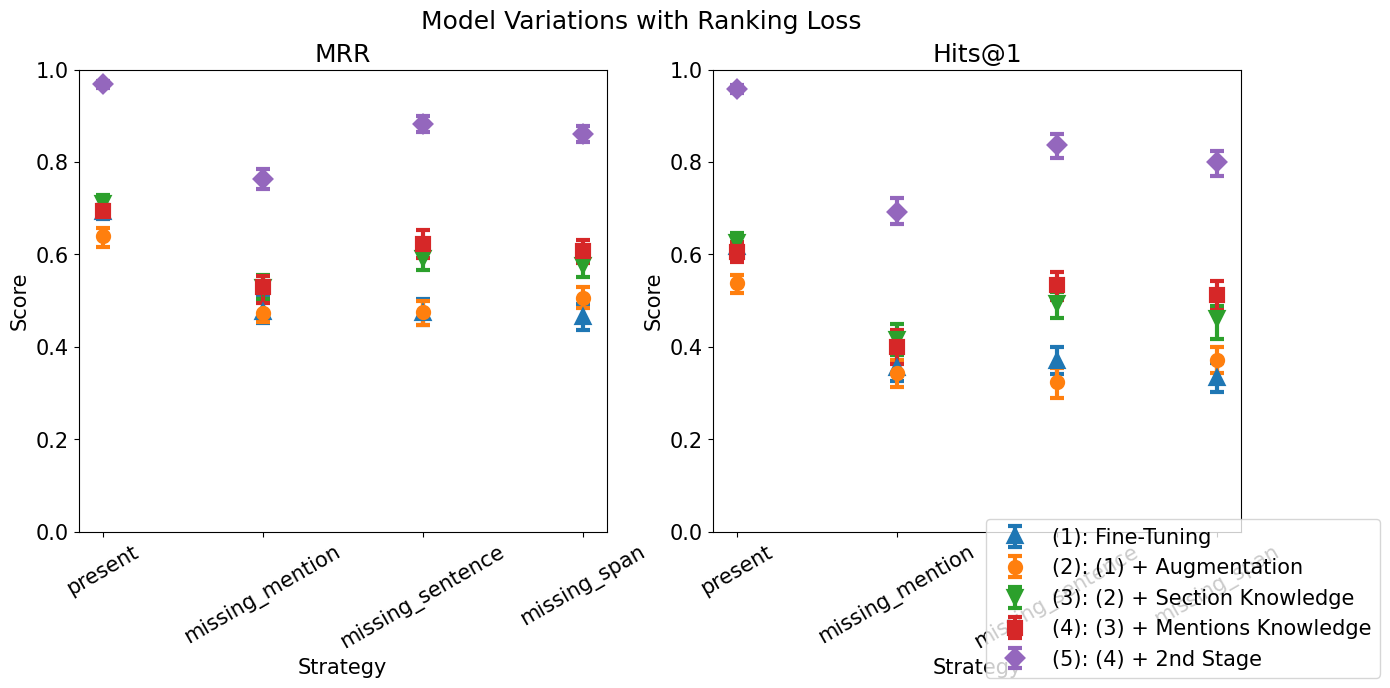

In [39]:
strategies = ['present', 'missing_mention', 'missing_sentence', 'missing_span']
columns = ['roberta_simple_v2_rank', 'roberta_mask_v2_rank', 'roberta_mask_section_v2_rank', 'roberta_mask_section_mention_v2_rank', 'roberta_two_stage_v2_rank']
labels = ['(1): Fine-Tuning', '(2): (1) + Augmentation', '(3): (2) + Section Knowledge', '(4): (3) + Mentions Knowledge', '(5): (4) + 2nd Stage']
markers = ['^', 'o', 'v', 's', 'D']

fig, axs = plt.subplots(1, 2, figsize=(15, 6))
fig.suptitle('Model Variations with Ranking Loss')
for i, ax in enumerate(axs):
    ax.set_ylim(0, 1)
    ax.set_xlabel('Strategy')
    ax.set_ylabel('Score')
    ax.set_title("MRR" if i == 0 else "Hits@1")

for column, label, marker in zip(columns, labels, markers):
    axs[0].errorbar(strategies, [stratified_mrr_at_k[column][s]['max']['score'] for s in strategies], yerr=[[stratified_mrr_at_k[column][s]['max']['score'] - stratified_mrr_at_k[column][s]['max']['cl'][0] for s in strategies], [stratified_mrr_at_k[column][s]['max']['cl'][1] - stratified_mrr_at_k[column][s]['max']['score'] for s in strategies]], label=label, marker=marker, capsize=5, linestyle='None', markersize=8, elinewidth=3, markeredgewidth=3)
    axs[1].errorbar(strategies, [stratified_hits_at_k[column][s]['1']['score'] for s in strategies], yerr=[[stratified_hits_at_k[column][s]['1']['score'] - stratified_hits_at_k[column][s]['1']['cl'][0] for s in strategies], [stratified_hits_at_k[column][s]['1']['cl'][1] - stratified_hits_at_k[column][s]['1']['score'] for s in strategies]], label=label, marker=marker, capsize=5, linestyle='None', markersize=8, elinewidth=3, markeredgewidth=3)

handles, labels = axs[-1].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower right')

# rotate x ticks
for ax in axs:
    plt.sca(ax)
    plt.xticks(rotation=30)

## Compare impact of different stages

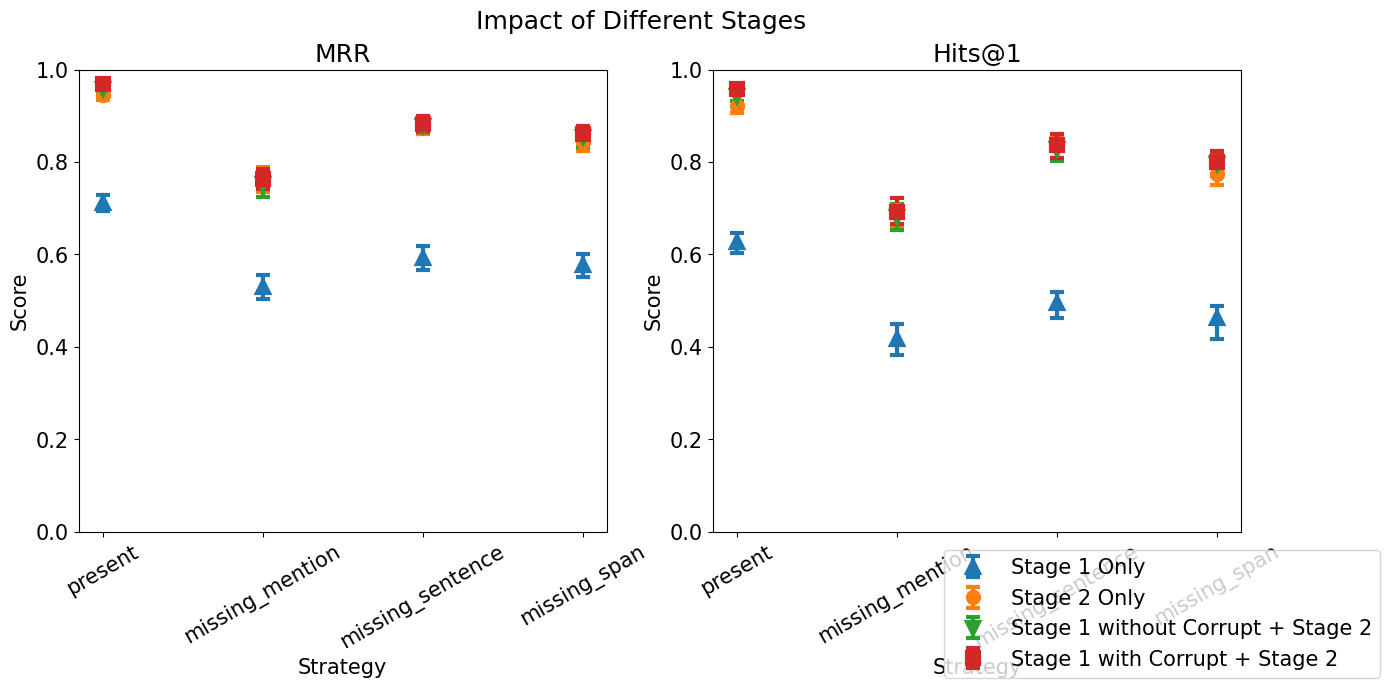

In [40]:
strategies = ['present', 'missing_mention', 'missing_sentence', 'missing_span']
columns = ['roberta_mask_section_v2_rank', 'roberta_only_stage_two_v2_rank', 'roberta_two_stage_no_corrupt_v2_rank', 'roberta_two_stage_v2_rank']
labels = ['Stage 1 Only', 'Stage 2 Only', 'Stage 1 without Corrupt + Stage 2', 'Stage 1 with Corrupt + Stage 2']
markers = ['^', 'o', 'v', 's']

fig, axs = plt.subplots(1, 2, figsize=(15, 6))
fig.suptitle('Impact of Different Stages')
for i, ax in enumerate(axs):
    ax.set_ylim(0, 1)
    ax.set_xlabel('Strategy')
    ax.set_ylabel('Score')
    ax.set_title("MRR" if i == 0 else "Hits@1")

for column, label, marker in zip(columns, labels, markers):
    axs[0].errorbar(strategies, [stratified_mrr_at_k[column][s]['max']['score'] for s in strategies], yerr=[[stratified_mrr_at_k[column][s]['max']['score'] - stratified_mrr_at_k[column][s]['max']['cl'][0] for s in strategies], [stratified_mrr_at_k[column][s]['max']['cl'][1] - stratified_mrr_at_k[column][s]['max']['score'] for s in strategies]], label=label, marker=marker, capsize=5, linestyle='None', markersize=8, elinewidth=3, markeredgewidth=3)
    axs[1].errorbar(strategies, [stratified_hits_at_k[column][s]['1']['score'] for s in strategies], yerr=[[stratified_hits_at_k[column][s]['1']['score'] - stratified_hits_at_k[column][s]['1']['cl'][0] for s in strategies], [stratified_hits_at_k[column][s]['1']['cl'][1] - stratified_hits_at_k[column][s]['1']['score'] for s in strategies]], label=label, marker=marker, capsize=5, linestyle='None', markersize=8, elinewidth=3, markeredgewidth=3)

handles, labels = axs[-1].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower right')

# rotate x ticks
for ax in axs:
    plt.sca(ax)
    plt.xticks(rotation=30)

## Compare training dataset size input

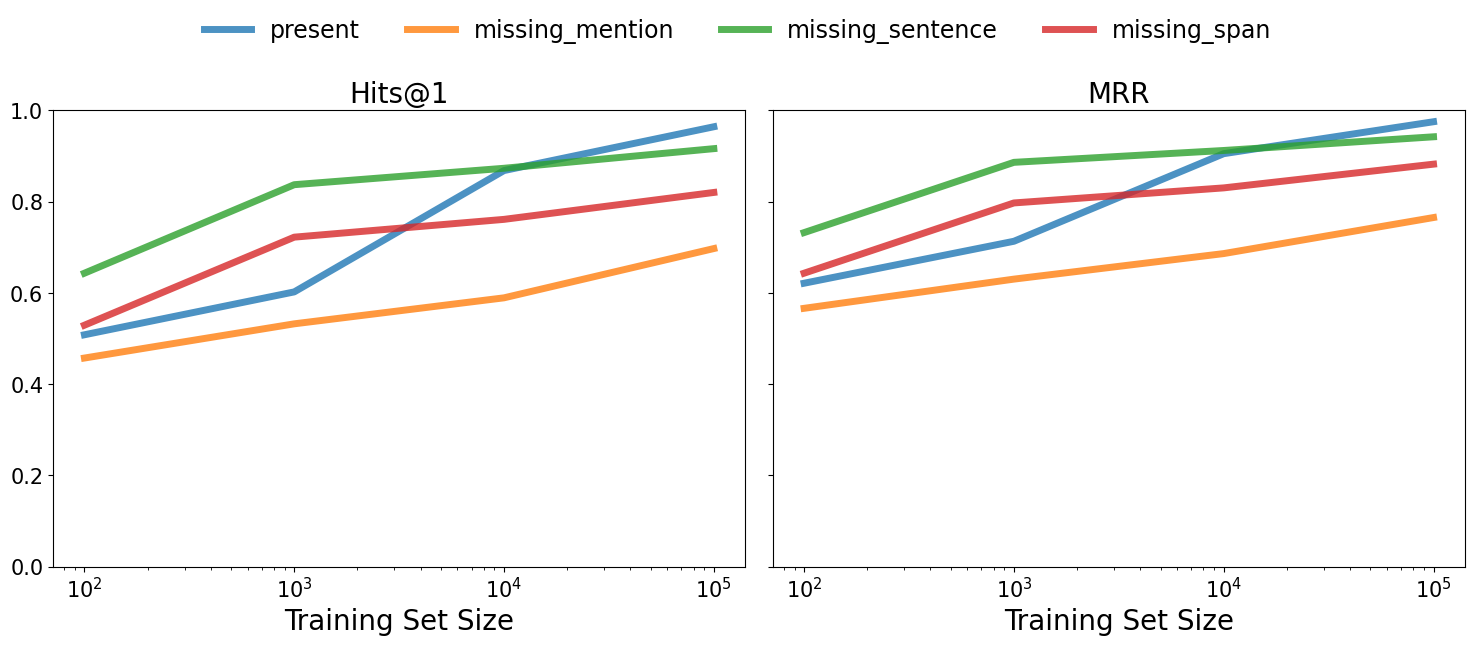

In [20]:
strategies = ['present', 'missing_mention', 'missing_sentence', 'missing_span']
columns = ['roberta_stage_2_100', 'roberta_stage_2_1000', 'roberta_stage_2_10000', 'roberta_stage_2_100000']
labels = [100, 1000, 10000, 100000]
markers = ['^', 'o', 'v', 's']

fig, axs = plt.subplots(1, 2, figsize=(15, 6))
# fig.suptitle('Impact of Training Set Size (Stage 2)', fontsize=25, fontweight='bold', y=1.08)
for strategy in strategies:
    axs[1].plot(labels, [stratified_mrr_at_k[column][strategy]['max']['score'] for column in columns], label=strategy, linewidth=5, alpha=0.8)
    axs[0].plot(labels, [stratified_hits_at_k[column][strategy]['1']['score'] for column in columns], label=strategy, linewidth=5, alpha=0.8)
    # axs[0].plot(labels, [stratified_mrr_at_k[column][strategy]['max']['score'] for column in columns], label=strategy)
    # axs[1].plot(labels, [stratified_hits_at_k[column][strategy]['1']['score'] for column in columns], label=strategy)

for i, ax in enumerate(axs):
    ax.set_ylim(0, 1)
    ax.set_xlabel('Training Set Size', fontsize=20)
    # ax.set_ylabel('Score', fontsize=20)
    ax.set_title("MRR" if i == 1 else "Hits@1", fontsize=20)
    for tick in ax.get_xticklabels():
        tick.set_fontsize(15)
    for tick in ax.get_yticklabels():
        tick.set_fontsize(15)
axs[1].set_ylabel('')
axs[1].set_yticklabels([])
    
handles, labels = axs[-1].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=4, fontsize=17, bbox_to_anchor=(0.5, 1.1), frameon=False)
# set legend to bold


axs[0].set_xscale('log')
axs[1].set_xscale('log')
plt.tight_layout()
plt.savefig('training_set_size_stage_2.pdf', bbox_inches='tight')

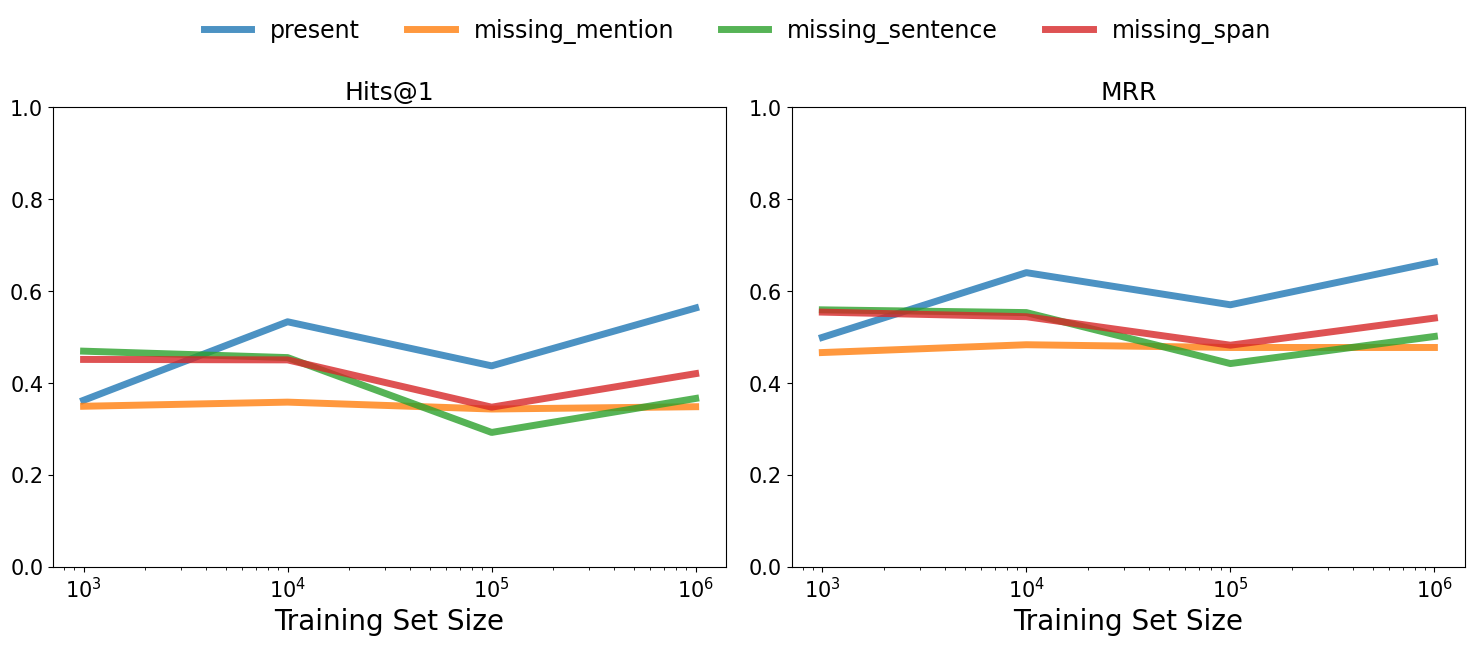

In [26]:
strategies = ['present', 'missing_mention', 'missing_sentence', 'missing_span']
columns = ['roberta_stage_1_1000', 'roberta_stage_1_10000', 'roberta_stage_1_100000', 'roberta_stage_1_1000000']
labels = [1000, 10000, 100000, 1000000]
markers = ['^', 'o', 'v', 's']

fig, axs = plt.subplots(1, 2, figsize=(15, 6))
# fig.suptitle('Impact of Training Set Size (Stage 1)')
for strategy in strategies:
    axs[1].plot(labels, [stratified_mrr_at_k[column][strategy]['max']['score'] for column in columns], label=strategy, linewidth=5, alpha=0.8)
    axs[0].plot(labels, [stratified_hits_at_k[column][strategy]['1']['score'] for column in columns], label=strategy, linewidth=5, alpha=0.8)
    # axs[0].plot(labels, [stratified_mrr_at_k[column][strategy]['max']['score'] for column in columns], label=strategy)
    # axs[1].plot(labels, [stratified_hits_at_k[column][strategy]['1']['score'] for column in columns], label=strategy)

for i, ax in enumerate(axs):
    ax.set_ylim(0, 1)
    ax.set_xlabel('Training Set Size', fontsize=20)
    # ax.set_ylabel('Score')
    ax.set_title("MRR" if i == 1 else "Hits@1")
    for tick in ax.get_xticklabels():
        tick.set_fontsize(15)
    for tick in ax.get_yticklabels():
        tick.set_fontsize(15)
    
handles, labels = axs[-1].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=4, fontsize=17, bbox_to_anchor=(0.5, 1.1), frameon=False)

axs[0].set_xscale('log')
axs[1].set_xscale('log')

plt.tight_layout()
plt.savefig('training_set_size_stage_1.pdf', bbox_inches='tight')

# Compare Ranking Loss with Independent Loss

## Simple Fine-Tuned Model

In [ ]:
strategies = ['present', 'missing_mention', 'missing_sentence', 'missing_span']
columns = ['model_indep_rank', 'model_ranking_rank']
labels = ['Independent Loss', 'Ranking Loss',]
markers = ['^', 'o']

fig, axs = plt.subplots(1, 2, figsize=(15, 6))
fig.suptitle('Ranking Loss vs Independent Loss (LM Fine-Tuning)')
for i, ax in enumerate(axs):
    ax.set_ylim(0, 1)
    ax.set_xlabel('Strategy')
    ax.set_ylabel('Score')
    ax.set_title("MRR" if i == 0 else "Hits@1")

for column, label, marker in zip(columns, labels, markers):
    axs[0].errorbar(strategies, [stratified_mrr_at_k[column][s]['max']['score'] for s in strategies], yerr=[[stratified_mrr_at_k[column][s]['max']['score'] - stratified_mrr_at_k[column][s]['max']['cl'][0] for s in strategies], [stratified_mrr_at_k[column][s]['max']['cl'][1] - stratified_mrr_at_k[column][s]['max']['score'] for s in strategies]], label=label, marker=marker, capsize=5, linestyle='None', markersize=8, elinewidth=3, markeredgewidth=3)
    axs[1].errorbar(strategies, [stratified_hits_at_k[column][s]['1']['score'] for s in strategies], yerr=[[stratified_hits_at_k[column][s]['1']['score'] - stratified_hits_at_k[column][s]['1']['cl'][0] for s in strategies], [stratified_hits_at_k[column][s]['1']['cl'][1] - stratified_hits_at_k[column][s]['1']['score'] for s in strategies]], label=label, marker=marker, capsize=5, linestyle='None', markersize=8, elinewidth=3, markeredgewidth=3)

handles, labels = axs[-1].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower right')

# rotate x ticks
for ax in axs:
    plt.sca(ax)
    plt.xticks(rotation=45)

# Model Fine-Tuned with Augmentations, Section Knowledge, Mention Knowledge

In [ ]:
strategies = ['present', 'missing_mention', 'missing_sentence', 'missing_span']
columns = ['model_indep_corrupt_section_mentions_rank', 'model_ranking_corrupt_section_mentions_rank']
labels = ['Independent Loss', 'Ranking Loss',]
markers = ['^', 'o']

fig, axs = plt.subplots(1, 2, figsize=(15, 6))
fig.suptitle('Ranking Loss vs Independent Loss (Fine-Tuning + Augmentations + Section Knowledge + Mentions Knowledge)')
for i, ax in enumerate(axs):
    ax.set_ylim(0, 1)
    ax.set_xlabel('Strategy')
    ax.set_ylabel('Score')
    ax.set_title("MRR" if i == 1 else "Hits@1")

for column, label, marker in zip(columns, labels, markers):
    axs[0].errorbar(strategies, [stratified_hits_at_k[column][s]['1']['score'] for s in strategies], yerr=[[stratified_hits_at_k[column][s]['1']['score'] - stratified_hits_at_k[column][s]['1']['cl'][0] for s in strategies], [stratified_hits_at_k[column][s]['1']['cl'][1] - stratified_hits_at_k[column][s]['1']['score'] for s in strategies]], label=label, marker=marker, capsize=5, linestyle='None', markersize=8, elinewidth=3, markeredgewidth=3)
    axs[1].errorbar(strategies, [stratified_mrr_at_k[column][s]['max']['score'] for s in strategies], yerr=[[stratified_mrr_at_k[column][s]['max']['score'] - stratified_mrr_at_k[column][s]['max']['cl'][0] for s in strategies], [stratified_mrr_at_k[column][s]['max']['cl'][1] - stratified_mrr_at_k[column][s]['max']['score'] for s in strategies]], label=label, marker=marker, capsize=5, linestyle='None', markersize=8, elinewidth=3, markeredgewidth=3)

handles, labels = axs[-1].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower right')

# rotate x ticks
for ax in axs:
    plt.sca(ax)
    plt.xticks(rotation=30)

## Compare 1-stage model with 2-stage model

In [ ]:
strategies = ['present', 'missing_mention', 'missing_sentence', 'missing_span']
columns = ['model_stage1_rank', 'model_stage2_long_rank']
labels = ['1 Stage', '2 Stages',]
markers = ['^', 'o']

fig, axs = plt.subplots(1, 2, figsize=(15, 6))
fig.suptitle('1st Stage Only vs 2 Stages')
for i, ax in enumerate(axs):
    ax.set_ylim(0, 1)
    ax.set_xlabel('Strategy')
    ax.set_ylabel('Score')
    ax.set_title("MRR" if i == 1 else "Hits@1")

for column, label, marker in zip(columns, labels, markers):
    axs[0].errorbar(strategies, [stratified_hits_at_k[column][s]['1']['score'] for s in strategies], yerr=[[stratified_hits_at_k[column][s]['1']['score'] - stratified_hits_at_k[column][s]['1']['cl'][0] for s in strategies], [stratified_hits_at_k[column][s]['1']['cl'][1] - stratified_hits_at_k[column][s]['1']['score'] for s in strategies]], label=label, marker=marker, capsize=5, linestyle='None', markersize=8, elinewidth=3, markeredgewidth=3)
    axs[1].errorbar(strategies, [stratified_mrr_at_k[column][s]['max']['score'] for s in strategies], yerr=[[stratified_mrr_at_k[column][s]['max']['score'] - stratified_mrr_at_k[column][s]['max']['cl'][0] for s in strategies], [stratified_mrr_at_k[column][s]['max']['cl'][1] - stratified_mrr_at_k[column][s]['max']['score'] for s in strategies]], label=label, marker=marker, capsize=5, linestyle='None', markersize=8, elinewidth=3, markeredgewidth=3)

handles, labels = axs[-1].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower right')

# rotate x ticks
for ax in axs:
    plt.sca(ax)
    plt.xticks(rotation=30)

In [ ]:
strategies = ['present', 'missing_mention', 'missing_sentence', 'missing_span']
columns = ['model_stage2_rank', 'model_stage2_long_rank']
labels = ['2nd Stage Short', '2nd Stage Long',]
markers = ['^', 'o']

fig, axs = plt.subplots(1, 2, figsize=(15, 6))
fig.suptitle('Impact of Number of Epochs of 2nd Stage')
for i, ax in enumerate(axs):
    ax.set_ylim(0, 1)
    ax.set_xlabel('Strategy')
    ax.set_ylabel('Score')
    ax.set_title("MRR" if i == 1 else "Hits@1")

for column, label, marker in zip(columns, labels, markers):
    axs[0].errorbar(strategies, [stratified_hits_at_k[column][s]['1']['score'] for s in strategies], yerr=[[stratified_hits_at_k[column][s]['1']['score'] - stratified_hits_at_k[column][s]['1']['cl'][0] for s in strategies], [stratified_hits_at_k[column][s]['1']['cl'][1] - stratified_hits_at_k[column][s]['1']['score'] for s in strategies]], label=label, marker=marker, capsize=5, linestyle='None', markersize=8, elinewidth=3, markeredgewidth=3)
    axs[1].errorbar(strategies, [stratified_mrr_at_k[column][s]['max']['score'] for s in strategies], yerr=[[stratified_mrr_at_k[column][s]['max']['score'] - stratified_mrr_at_k[column][s]['max']['cl'][0] for s in strategies], [stratified_mrr_at_k[column][s]['max']['cl'][1] - stratified_mrr_at_k[column][s]['max']['score'] for s in strategies]], label=label, marker=marker, capsize=5, linestyle='None', markersize=8, elinewidth=3, markeredgewidth=3)

handles, labels = axs[-1].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower right')

# rotate x ticks
for ax in axs:
    plt.sca(ax)
    plt.xticks(rotation=30)

# Presentation Plots

In [ ]:
strategies = ['present', 'missing_mention', 'missing_sentence', 'missing_span']
# columns = ['random_rank', 'bm25_mentions_rank', 'fuzzy_match_rank', 'model_ranking_rank', 'model_ranking_corrupt_section_mentions_rank']
# columns = ['random_rank', 'bm25_mentions_rank', 'fuzzy_match_rank', 'model_ranking_corrupt_section_mentions_rank']
# columns = ['random_rank', 'bm25_mentions_rank', 'fuzzy_match_rank', 'model_stage2_long_rank']
columns = ['random_rank', 'bm25_mentions_rank', 'fuzzy_match_rank', 'roberta_simple_v2_rank', 'roberta_two_stage_v2_rank']
labels = ['Random', 'BM25', 'String Match', 'LM Fine-Tuning', 'Ours']
# labels = ['Random', 'BM25', 'String Match', 'Ours']
markers = ['o', 'v', 's', '^', 'D']

fig, axs = plt.subplots(1, 2, figsize=(15, 6))
fig.suptitle('Ranking Performance Comparison')
for i, ax in enumerate(axs):
    ax.set_ylim(0, 1)
    ax.set_xlabel('Strategy')
    ax.set_ylabel('Score')
    ax.set_title("MRR" if i == 1 else "Hits@1")

for column, label, marker in zip(columns, labels, markers):
    axs[0].errorbar(strategies, [stratified_hits_at_k[column][s]['1']['score'] for s in strategies], yerr=[[stratified_hits_at_k[column][s]['1']['score'] - stratified_hits_at_k[column][s]['1']['cl'][0] for s in strategies], [stratified_hits_at_k[column][s]['1']['cl'][1] - stratified_hits_at_k[column][s]['1']['score'] for s in strategies]], label=label, marker=marker, capsize=5, linestyle='None', markersize=8, elinewidth=3, markeredgewidth=3)
    axs[1].errorbar(strategies, [stratified_mrr_at_k[column][s]['max']['score'] for s in strategies], yerr=[[stratified_mrr_at_k[column][s]['max']['score'] - stratified_mrr_at_k[column][s]['max']['cl'][0] for s in strategies], [stratified_mrr_at_k[column][s]['max']['cl'][1] - stratified_mrr_at_k[column][s]['max']['score'] for s in strategies]], label=label, marker=marker, capsize=5, linestyle='None', markersize=8, elinewidth=3, markeredgewidth=3)

handles, labels = axs[-1].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower right')

# rotate x ticks
for ax in axs:
    plt.sca(ax)
    plt.xticks(rotation=30)

In [ ]:
strategies = ['present', 'missing_mention', 'missing_sentence', 'missing_span']
columns = ['model_ranking_corrupt_section_mentions_rank', 'model_ranking_corrupt_section_mentions_negmask_rank', 'model_ranking_corrupt_section_mentions_negmask_2_rank', 'model_ranking_corrupt_section_mentions_negmask_2_largemask_rank']
labels = ['Baseline', 'Masked Negatives', 'Masked Negatives + Correct Sampling', 'Masked Negatives + Correct Sampling + Large Mask']
markers = ['o', 'v', 's', '^', 'D']

fig, axs = plt.subplots(1, 2, figsize=(15, 6))
fig.suptitle('Ranking Performance Comparison')
for i, ax in enumerate(axs):
    ax.set_ylim(0, 1)
    ax.set_xlabel('Strategy')
    ax.set_ylabel('Score')
    ax.set_title("MRR" if i == 1 else "Hits@1")

for column, label, marker in zip(columns, labels, markers):
    axs[0].errorbar(strategies, [stratified_hits_at_k[column][s]['1']['score'] for s in strategies], yerr=[[stratified_hits_at_k[column][s]['1']['score'] - stratified_hits_at_k[column][s]['1']['cl'][0] for s in strategies], [stratified_hits_at_k[column][s]['1']['cl'][1] - stratified_hits_at_k[column][s]['1']['score'] for s in strategies]], label=label, marker=marker, capsize=5, linestyle='None', markersize=8, elinewidth=3, markeredgewidth=3)
    axs[1].errorbar(strategies, [stratified_mrr_at_k[column][s]['max']['score'] for s in strategies], yerr=[[stratified_mrr_at_k[column][s]['max']['score'] - stratified_mrr_at_k[column][s]['max']['cl'][0] for s in strategies], [stratified_mrr_at_k[column][s]['max']['cl'][1] - stratified_mrr_at_k[column][s]['max']['score'] for s in strategies]], label=label, marker=marker, capsize=5, linestyle='None', markersize=8, elinewidth=3, markeredgewidth=3)

handles, labels = axs[-1].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower right')

# rotate x ticks
for ax in axs:
    plt.sca(ax)
    plt.xticks(rotation=30)